In [1]:
import sqlite3
con = sqlite3.connect("./database.sqlite")

In [2]:
import pandas as pd

In [3]:
filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score!=3 LIMIT 1000",con)

In [4]:
type(filtered_data)

pandas.core.frame.DataFrame

In [5]:
actual_score = filtered_data["Score"]

In [6]:
def partition(x):
    if x>3:
        return 1
    else:
        return 0

In [7]:
actual_score2 = actual_score.map(partition)    ####actual_score2 contains positive(1) and negative(0)

In [8]:
actual_score2

0      1
1      0
2      1
3      0
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: Score, Length: 1000, dtype: int64

In [9]:
del filtered_data["Score"]

In [10]:
filtered_data.shape

(1000, 9)

In [11]:
from sklearn.manifold import TSNE

In [12]:
model = TSNE(n_components = 2 , random_state = 2)

In [13]:
filtered_data['Score'] = actual_score2

In [14]:
filtered_data.shape

(1000, 10)

In [15]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [16]:
##### now the most important visible feature is text and summary but we have to convert this text to vectors for classification purpose
#### many ways of converting texts to vectors are "bag of words" "binary bag of wods" "tf-idf" "w2v" ...we will apply one after one
## all the three methods of text to vector conversion

In [17]:
### but first we have to perform deduplication and reduce bad data

In [18]:
sorted_data = filtered_data.sort_values('ProductId' , axis = 0 , ascending = True)

In [19]:
deduplicated_data = sorted_data.drop_duplicates(subset = { "UserId" , "ProfileName" ,"Time"} , inplace =False ,keep="first")

In [20]:
deduplicated_data.shape

(986, 10)

In [21]:
### removing reviews where helpfullness numerator is greater then helpfullness deominator

In [22]:
deduplicated_data = deduplicated_data[deduplicated_data.HelpfulnessNumerator<=deduplicated_data.HelpfulnessDenominator]

In [23]:
deduplicated_data.shape

(986, 10)

In [24]:
deduplicated_data["Score"].value_counts()

1    829
0    157
Name: Score, dtype: int64

####bag of words code

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
count_vector = CountVectorizer(lowercase=True)

In [27]:
text_vectors = count_vector.fit_transform(deduplicated_data['Text'].values)

In [28]:
text_vectors.shape

(986, 6025)

In [29]:
type(text_vectors)

scipy.sparse.csr.csr_matrix

In [30]:
print(text_vectors[1])

  (0, 5387)	1
  (0, 3672)	1
  (0, 2735)	2
  (0, 5469)	1
  (0, 2123)	1
  (0, 3400)	1
  (0, 5360)	1
  (0, 5805)	1
  (0, 674)	1
  (0, 3641)	1
  (0, 540)	1
  (0, 2789)	1
  (0, 1347)	1
  (0, 2475)	1
  (0, 3579)	1
  (0, 1761)	1
  (0, 1866)	1
  (0, 583)	1
  (0, 1693)	2
  (0, 5520)	1
  (0, 1635)	1
  (0, 4869)	1
  (0, 2837)	1


In [31]:
###### we have imported TSNE earlier and now performing tsne on text vectors which we have created using ''bag of words method''
#### now we plot to see if the db +ve,-ve reviews classifiable on text vectors created by 'BOG'

In [32]:
reduced_data = model.fit_transform(text_vectors)

In [33]:
reduced_data.shape

(986, 2)

In [34]:
type(reduced_data)

numpy.ndarray

In [35]:
import numpy as np

In [36]:
reduced_data[1]

array([-2.600569 ,  3.7934914], dtype=float32)

In [37]:
data_set_2d = np.vstack((reduced_data.T,deduplicated_data['Score'])).T

In [38]:
data_set_2d[1]

array([-2.60056901,  3.79349136,  0.        ])

In [39]:
amazon_2d_df= pd.DataFrame(data = data_set_2d , columns = ("feature1" , "feature2" ,"score"))

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

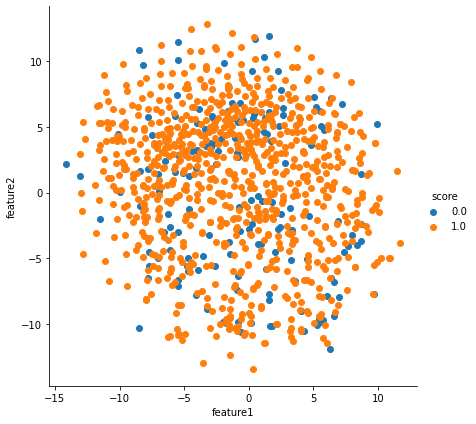

In [41]:
sns.FacetGrid(data = amazon_2d_df , hue = 'score' , height = 6).map( plt.scatter , "feature1" , "feature2" ).add_legend()
plt.show()

In [42]:
###### from above plot we can see that "BOW" vectors does not classify 1 and 0 properly

In [43]:
import nltk

In [44]:
### text preprocessing like stemming lemitisation 

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))   #### stop words set
stem = nltk.stem.SnowballStemmer('english')   ###stems

In [45]:
stem         ###3 stem is an object of SnowballStemmer class

In [46]:
print(stop)

{'my', 'her', 'an', 'will', 't', 'you', "mustn't", 'i', 'there', 'now', 'over', 'but', 'these', 'once', "that'll", 'under', 'itself', 'when', 'of', 'can', 'mightn', 'through', 'nor', 'theirs', 'so', 'only', 'won', 'is', 'himself', 'its', 'as', 'with', 'herself', 'or', 'have', 'the', 'from', "you'd", 'does', 'them', 'haven', 'needn', 'shan', 'couldn', 'being', 'just', 'than', 've', "shouldn't", 'in', 'been', 'at', "you've", 'a', 'while', 'below', 'm', "weren't", 'o', 'he', 'if', 'yours', 'after', 'between', 'yourselves', 'and', 'other', 'by', 'hers', 'to', "you'll", 'ain', 'isn', 'ma', 'him', 'our', 'out', 'do', "needn't", 'his', 'until', 'too', "you're", "it's", 'any', 'down', 'shouldn', 'was', 'should', 'themselves', 'their', "aren't", "mightn't", 'because', 'did', "she's", 'some', 'yourself', "hadn't", 'it', "didn't", 'before', 'against', "wouldn't", "won't", 'why', 'again', 'your', 'we', 'most', 'ourselves', 'such', 'this', "should've", 'more', 'own', "hasn't", 'had', 'she', 'who', 

In [47]:
def removehtml(sentence):
    pattern = re.compile('<.*?')
    new_sentence = re.sub(pattern,' ',sentence)
    return new_sentence


def removepunct(sentence):
    new_sentence = re.sub(r'[^\w\s]','',sentence)
    ##new_sentence2 = re.sub(r'/|\\\]',r' ',new_sentence)
    return new_sentence

In [48]:
print(stem.stem('tasty'))

tasti


In [49]:
print((deduplicated_data['Text'].values)[1])

Five minutes in, one tentacle was bitten off, ball inside cracked in half. Not durable enough to be a dog toy. Disappointed :(. So is the dog :(.


In [148]:
#####deduplicated_data["HelpfulnessNumerator"][29]    dont know why 29 ,392,402 and several other rows arer absent and when accessed give error trying to figure out look both
### this and google drive file if confused

In [146]:
### applying the text preprocesing step by step
i = 0
positive_words = []
negative_words = []
text_list = []
for text in deduplicated_data['Text'].values:
    filtered_list=[]
    string = ""
    sentence = removehtml(text)
    for w in sentence.split():
        for words in removepunct(w).split():
            if((words.isalpha()) & (len(words)>2)):        ##### as it is found that length of any adjective is greaater then 2
                words=words.lower()
                if(words not in stop):
                    words = (stem.stem(words)).encode('utf8')
                    filtered_list.append(words)
                    if((deduplicated_data['Score'].values)[i]==1):
                        positive_words.append(words)
                    else:
                        negative_words.append(words)
                else:
                    continue
            else:
                continue
    string = b' '.join(filtered_list)
    text_list.append(string)
    i+=1
            
                    
                

In [51]:
filtered_list

[b'tri',
 b'avail',
 b'tdisc',
 b'kona',
 b'blend',
 b'one',
 b'best',
 b'regularunflavor',
 b'coffe',
 b'tassimo',
 b'nice',
 b'smooth',
 b'flavor',
 b'overpow',
 b'pleasant',
 b'aroma',
 b'person',
 b'would',
 b'enjoy',
 b'strongerbold',
 b'howev',
 b'bit',
 b'mild',
 b'goe',
 b'well',
 b'breakfast',
 b'andor',
 b'glutenfre',
 b'bake',
 b'goodi',
 b'find',
 b'mild',
 b'perplex',
 b'product',
 b'avail',
 b'tassimodirect',
 b'subscript',
 b'servic',
 b'avail',
 b'origin',
 b'found',
 b'dead',
 b'bat',
 b'beyond',
 b'use',
 b'coupon',
 b'happi',
 b'final',
 b'price']

In [52]:
print(text_list[1])

b'five minut one tentacl bitten ball insid crack half durabl enough dog toy disappoint dog'


In [53]:
print(len(text_list))

986


In [54]:
deduplicated_data['Cleaned_text'] = text_list

In [55]:
deduplicated_data.shape

(986, 11)

In [56]:
#### storing the new database into a new sqlite file

conn = sqlite3.connect('final.sqlite')

In [57]:
cursor_object = conn.cursor()
conn.text_factory = str                ####Using this attribute you can control what objects are returned for the TEXT data type

In [58]:
type(deduplicated_data)

pandas.core.frame.DataFrame

In [59]:
deduplicated_data.to_sql('Reviews', conn ,schema = None ,if_exists='replace' ,index = False )      #### a new db is created and written

In [60]:
###### now checking whether the data is written in sql or not

In [61]:
final_database = pd.read_sql_query('SELECT * FROM Reviews',conn)

In [62]:
final_database.shape

(986, 11)

In [63]:
final_database.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score,Cleaned_text
0,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1,b'dont know cactus tequila uniqu combin ingred...
1,253,B0002567IW,A1SSKFPX72MSMR,"Janna M. Sicard ""missjanna""",0,0,1344556800,Sad outcome,"Five minutes in, one tentacle was bitten off, ...",0,b'five minut one tentacl bitten ball insid cra...
2,188,B00029XIZI,A2S72TUJDQUBMH,Nadia,0,0,1236124800,Miracle,My Scotties were full of hot spots and when I ...,1,b'scotti full hot spot use within week hot spo...
3,1011,B0002MKFEM,A3QLX72AO0DD5Z,Carlito Picache,1,2,1226361600,Way too salty,I tried this and I found it too salty.<br />Pl...,1,b'tri found salti plus ate fish sauc fish real...
4,969,B0002XIB2Y,A3NV17B17PFB7G,Susan,3,3,1228176000,WONDERFUL gravy!,"This gravy mix is excellent ... except, don't ...",1,b'gravi mix excel except dont use water call u...


In [64]:
conn.close()        #### successfully closed

In [65]:
##### now having a look at the frequency distribution of positive and negative lists

In [66]:
frequency_dist_positive = nltk.FreqDist(positive_words)
frequency_dist_negative = nltk.FreqDist(negative_words)

In [67]:
print('Most common 20 words in positive_words: ',frequency_dist_positive.most_common(20))
print('Most common 20 words in negative_words: ',frequency_dist_negative.most_common(20))

Most common 20 words in positive_words:  [(b'chip', 475), (b'like', 350), (b'flavor', 349), (b'tast', 303), (b'good', 290), (b'love', 289), (b'great', 272), (b'use', 244), (b'one', 237), (b'bag', 236), (b'food', 215), (b'tea', 212), (b'tri', 198), (b'product', 194), (b'best', 151), (b'make', 149), (b'get', 148), (b'eat', 148), (b'price', 144), (b'buy', 141)]
Most common 20 words in negative_words:  [(b'chip', 106), (b'tast', 98), (b'like', 91), (b'product', 68), (b'bag', 63), (b'one', 55), (b'food', 52), (b'flavor', 51), (b'use', 46), (b'kettl', 46), (b'tri', 43), (b'would', 43), (b'good', 41), (b'box', 40), (b'eat', 38), (b'brand', 38), (b'look', 35), (b'buy', 34), (b'dont', 34), (b'even', 32)]


In [68]:
###### we can see that word like tast and like occurs in both positive and negative reviews so we can not differenciate reviews
##### as positive and negative on basis of  word lists

In [69]:
 #### now trying bi-gram and tri-gram

In [70]:
count_vector = CountVectorizer(lowercase = True , ngram_range = (1,2))

In [71]:
bigram = count_vector.fit_transform(deduplicated_data["Text"].values)

In [72]:
bigram.shape

(986, 43589)

In [73]:
type(bigram)

scipy.sparse.csr.csr_matrix

In [74]:
bigram_tsne= model.fit_transform(bigram)

In [75]:
bigram_tsne.shape

(986, 2)

In [76]:
bigram_tsne_3d = np.vstack((bigram_tsne.T,deduplicated_data["Score"])).T

In [77]:
bigram_tsne_3d.shape

(986, 3)

In [78]:
bigram_tsne_3d_df = pd.DataFrame(data = bigram_tsne_3d ,columns = ( "features1" , "features2" , "score"))

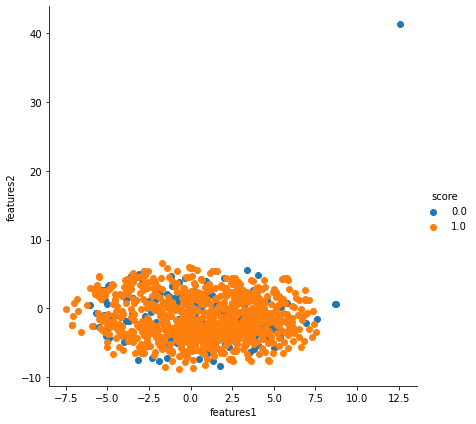

In [79]:
sns.FacetGrid(bigram_tsne_3d_df , hue = 'score' , height = 6).map( plt.scatter , 'features1' , 'features2').add_legend()
plt.show()

In [80]:
#### this is also not much clear

In [81]:
#### lets perform tf-idf

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [83]:
count_vector = TfidfVectorizer(ngram_range = (1,2))

In [84]:
tfidf_vector = count_vector.fit_transform(deduplicated_data["Text"].values)

In [85]:
tfidf_vector.shape

(986, 43589)

In [86]:
tfidf_2d = model.fit_transform(tfidf_vector)

In [87]:
tfidf_3d = np.vstack((tfidf_2d.T,deduplicated_data["Score"].values)).T
tfidf_3d_df = pd.DataFrame(data = tfidf_3d ,columns = ( 'features1' , 'features2' , 'score' ))

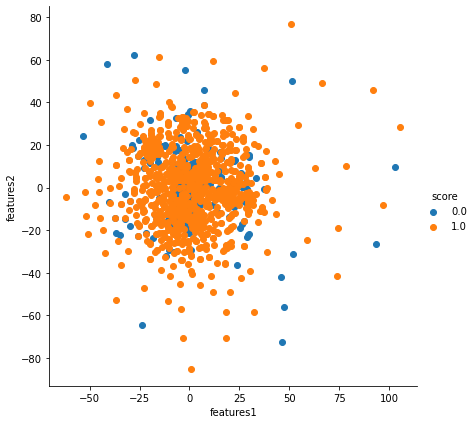

In [88]:
sns.FacetGrid(tfidf_3d_df , hue = 'score' , height= 6).map( plt.scatter , 'features1' , 'features2').add_legend()
plt.show()

In [89]:
##### we can also see that tfidf does not clearly classify

In [90]:
from sklearn.feature_extraction import DictVectorizer

In [91]:
features =count_vector.get_feature_names()

In [92]:
len(features)

43589

In [93]:
print(features[100000:100100])

[]


In [94]:
def top_25_tfidf( rows , features , top_n=25):
    arguments = np.argsort(rows)[::-1][:top_n]
    feature_n_tf = [(features[i],rows[i]) for i in arguments]
    feature_d_f = pd.DataFrame(data = feature_n_tf ,columns = ("feature" , "tf"))
    return feature_d_f

In [95]:
feature_df = top_25_tfidf(tfidf_vector[1,:].toarray()[0],features,25)

In [96]:
feature_df

,feature,tf
0,dog,0.231876
1,inside cracked,0.175436
2,bitten,0.175436
3,ball inside,0.175436
4,durable,0.175436
5,durable enough,0.175436
6,be dog,0.175436
7,so is,0.175436
8,off ball,0.175436
9,one tentacle,0.175436


In [97]:
!pip3 install gensim


In [98]:
import gensim

i = 0
filtered_list = []
for sent in deduplicated_data['Text']:
    filtered_data = []
    sent = removehtml(sent)
    for word in sent.split():
        for words in removepunct(word).split():
            if(words.isalpha()):
                filtered_data.append(words)
            else:
                continue
                
    filtered_list.append(filtered_data)

In [99]:
print(filtered_list[0])
print(deduplicated_data['Text'].values[0])

['I', 'dont', 'know', 'if', 'its', 'the', 'cactus', 'or', 'the', 'tequila', 'or', 'just', 'the', 'unique', 'combination', 'of', 'ingredients', 'but', 'the', 'flavour', 'of', 'this', 'hot', 'sauce', 'makes', 'it', 'one', 'of', 'a', 'kind', 'We', 'picked', 'up', 'a', 'bottle', 'once', 'on', 'a', 'trip', 'we', 'were', 'on', 'and', 'brought', 'it', 'back', 'home', 'with', 'us', 'and', 'were', 'totally', 'blown', 'away', 'When', 'we', 'realized', 'that', 'we', 'simply', 'couldnt', 'find', 'it', 'anywhere', 'in', 'our', 'city', 'we', 'were', 'bummed', 'br', 'br', 'Now', 'because', 'of', 'the', 'magic', 'of', 'the', 'internet', 'we', 'have', 'a', 'case', 'of', 'the', 'sauce', 'and', 'are', 'ecstatic', 'because', 'of', 'it', 'br', 'br', 'If', 'you', 'love', 'hot', 'sauceI', 'mean', 'really', 'love', 'hot', 'sauce', 'but', 'dont', 'want', 'a', 'sauce', 'that', 'tastelessly', 'burns', 'your', 'throat', 'grab', 'a', 'bottle', 'of', 'Tequila', 'Picante', 'Gourmet', 'de', 'Inclan', 'Just', 'realize

In [100]:
len(filtered_list)

986

In [150]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [151]:
w2v = gensim.models.Word2Vec( filtered_list ,min_count = 5,size = 50)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [103]:
words = list(w2v.wv.vocab)

In [104]:
len(words)

1561

In [105]:
words[1]

'dont'

In [106]:
w2v.wv.most_similar('tasty')

[('through', 0.9997868537902832),
 ('by', 0.9997845888137817),
 ('over', 0.9997729063034058),
 ('chocolate', 0.9997695684432983),
 ('which', 0.9997686743736267),
 ('coffee', 0.9997630715370178),
 ('from', 0.999760627746582),
 ('even', 0.9997589588165283),
 ('some', 0.9997493624687195),
 ('also', 0.9997437596321106)]

In [107]:
w2v.wv.similarity('tasty','delicious')

0.99971426

In [108]:
###### average w2v or tfidf-w2v

In [109]:
w2v.wv['why']

array([ 0.25646833, -0.19369595,  0.1126451 ,  0.18788096, -0.24539158,
       -0.23018934, -0.08914137,  0.28373784, -0.3554743 , -0.39055935,
        0.16729853,  0.32485318,  0.21785314, -0.1807535 ,  0.23811688,
       -0.07055927,  0.4632081 ,  0.5695034 , -0.26643875, -0.48862875,
        0.04157119, -0.20360574, -0.3140269 ,  0.01905161,  0.03379994,
       -0.6428288 , -0.45104557,  0.00466424, -0.04151287, -0.27265692,
       -0.30575484,  0.29375756, -0.34364852, -0.18786731, -0.23990728,
        0.06124392, -0.44332168, -0.0944785 , -0.5215535 , -0.1193359 ,
       -0.14780888,  0.03603813, -0.13592201,  0.12825245, -0.17581163,
        0.37237343, -0.08440948,  0.2915942 , -0.13830845, -0.03022292],
      dtype=float32)

In [110]:
avrg_vector = []
for sent in filtered_list:
    word_vector=np.zeros(50)
    count = 0
    for words in sent:
        try:
            vec = w2v.wv[words]
            word_vector += vec
            count +=1
        except:
            pass
    word_vector /= count
    avrg_vector.append(word_vector)   
    

In [111]:
avrg_vector[0]

array([ 0.37779356, -0.29224067,  0.15246546,  0.27656074, -0.37506517,
       -0.34913172, -0.1384853 ,  0.43164888, -0.54468321, -0.58199086,
        0.25590308,  0.49791755,  0.31884894, -0.28274715,  0.35425208,
       -0.10891031,  0.69207585,  0.84935109, -0.38273168, -0.71200835,
        0.04739395, -0.31742457, -0.46939643,  0.03754349,  0.06153447,
       -0.95306146, -0.67511104,  0.01384567, -0.05328383, -0.39507021,
       -0.46289812,  0.43400364, -0.5178891 , -0.2735992 , -0.35442781,
        0.08650016, -0.65513472, -0.14725887, -0.76325859, -0.18484177,
       -0.21632564,  0.04308091, -0.212119  ,  0.1936789 , -0.27444921,
        0.56523906, -0.13434205,  0.42819869, -0.20175522, -0.06557143])

In [112]:
len(avrg_vector)

986

In [113]:
len(avrg_vector[0])

50

In [114]:
tfidf_array = tfidf_vector.toarray()

In [115]:
##### tfidf-w2v

In [116]:
tfidf_w2v = []
row = 0
for sent in filtered_list:
    vector = np.zeros(50)
    summation = 0
    for word in sent:
        try:
            tf = tfidf_vector[row,features.index(word)]
            print(tf)
            value = tf * w2v.wv[word]
            vector += value
            summation += tf
        except:
            pass
    vector = vector/summation
    tfidf_w2v.append(vector)
    row +=1
    
        

0.0
0.035943781463544607
0.050997358267925126
0.0
0.09619902978011076
0.07126945621283924
0.049683604173827674
0.09619902978011076
0.13451358824510118
0.049683604173827674
0.051890421846155214
0.09619902978011076
0.04898967658742165
0.051329084515106885
0.12167302034926906
0.04067913259674416
0.03964565948380632
0.09619902978011076
0.06440976506111287
0.12167302034926906
0.015312575618768517
0.11707767440725078
0.2611569699490913
0.039818029515645115
0.08913206817935782
0.02599609248712296
0.12167302034926906
0.04551208763852056
0.05887155964597159
0.03108551581358139
0.09335544133474298
0.08705232331636377
0.043363985208420865
0.06039710297082422
0.18255305080101952
0.08831651847123415
0.043363985208420865
0.035888728689590164
0.054398514900196905
0.08913206817935782
0.04266505857708283
0.043230723527703956
0.019526587578243923
0.043526161658181885
0.035888728689590164
0.08831651847123415
0.056384440880535576
0.07126945621283924
0.04383069160593375
0.18255305080101952
0.05755007390938

0.17503155899718398
0.12945631702775345
0.14788212555128813
0.1071700935662584
0.04405380243777445
0.09391994999025126
0.17503155899718398
0.06999683148099371
0.11708780075514566
0.11020416952394106
0.05493267961169603
0.10813712536558526
0.05493267961169603
0.05521723680546153
0.1178494303386078
0.11638299782802572
0.06999683148099371
0.11708780075514566
0.1386692212895208
0.10366750992407721
0.0349195204609557
0.08220762544285984
0.044832228049493196
0.05956911868162809
0.08960181389430844
0.16363168941291936
0.0326360682888926
0.06860790854597064
0.09189890142994885
0.03410724984697433
0.154418785151152
0.06663831530645402
0.033154192935947846
0.05523278739398063
0.05791957071083525
0.05943603157742445
0.10609256106194169
0.3323461371349638
0.09960210182104565
0.07324777269899323
0.09091759476625608
0.07024062011930307
0.1107820457116546
0.06592946764280047
0.07169412835353728
0.051774536421077266
0.09960210182104565
0.10609256106194169
0.039409419118598646
0.06815577555791447
0.036

0.03751990151299286
0.042454559609103944
0.0680926583258182
0.11028068337062091
0.07514217349934915
0.06524268879201132
0.13657053415742942
0.07514217349934915
0.11028068337062091
0.055599485002508185
0.029210431973735167
0.04886200084415427
0.07752546032804399
0.07271273641390176
0.1821931272537169
0.06877199725968178
0.11540196359400785
0.08792853013967492
0.06877199725968178
0.06257306137361664
0.05311697622705685
0.08340727519693966
0.13004689596796595
0.032166773548714056
0.023042747869544876
0.07591051754432686
0.06941936130269942
0.05663284649233456
0.08311134171173845
0.3334240387055268
0.1130684584315252
0.12028020261255397
0.1130684584315252
0.031073695915521976
0.0801262341974778
0.039201983383606254
0.12974334668436246
0.11519878212994579
0.3334240387055268
0.045264672954356384
0.03592119118208724
0.09712634397345703
0.19245511429894988
0.09374861491381883
0.05927967521607495
0.07934847006899075
0.12974334668436246
0.05084713011748411
0.13741203516229192
0.02444136344866516

0.0634771701493737
0.1682425051782352
0.055344635864424105
0.06706754962478184
0.06449392969976885
0.029757520392173165
0.0768449727794038
0.0768449727794038
0.03817087761984019
0.060795480348650274
0.06407000246650588
0.0631625455276511
0.09451926483911194
0.13413509924956368
0.0997347759231546
0.06449392969976885
0.26032315651321425
0.05865419239711483
0.03128450026153893
0.07020224240054802
0.02381380489884049
0.07020224240054802
0.26032315651321425
0.05687161573378986
0.0648280151982372
0.06449392969976885
0.055344635864424105
0.0648280151982372
0.08975708870979195
0.0997347759231546
0.0681681981251379
0.03437915904002686
0.04675641487983254
0.027974943728848206
0.0648280151982372
0.018077807727079905
0.06544006627122803
0.0634771701493737
0.050783527842164326
0.0681681981251379
0.04315770743539095
0.0648280151982372
0.08975708870979195
0.0997347759231546
0.07251839410900802
0.06449392969976885
0.26032315651321425
0.016436011352996494
0.03246696223963206
0.06944863768944184
0.06706

0.13180558505502712
0.033190887727928976
0.08952267030343053
0.023271446238622283
0.13180558505502712
0.02876965001047279
0.07678104438723829
0.03478277733010852
0.022312329319069388
0.019529861457658226
0.039210717427256306
0.10440176239466173
0.06596541639598948
0.03139725738304396
0.01781085910547123
0.13773712937575006
0.12844480996643665
0.009145022425584091
0.050113014092297715
0.15135852358827698
0.11198878619729596
0.1021399182998961
0.1021399182998961
0.07508419568852619
0.13180558505502712
0.038873574161780375
0.06596541639598948
0.04817181037903411
0.06927515562541582
0.0851459217941787
0.050645743869473445
0.01642406547599602
0.10440176239466173
0.081027746589778
0.07508419568852619
0.13180558505502712
0.038873574161780375
0.023741130676568245
0.03294330259068336
0.13773712937575006
0.03018588333945695
0.03211120249160916
0.08295743771900414
0.13773712937575006
0.030754615800550403
0.01975959680111649
0.10440176239466173
0.021948283591249444
0.13548095868820337
0.0158258933

0.041518454792919025
0.041702072113646495
0.04804980813048104
0.07647964019956452
0.04328839433521646
0.033240758647731794
0.05199386933161022
0.07322737115177347
0.102165854941915
0.0649900436327439
0.10619693414670445
0.06005211817353612
0.07923724316074825
0.06109337935372706
0.039526596632633505
0.0470756587353363
0.019409011055492892
0.0649900436327439
0.07923724316074825
0.04266951562508437
0.055958602200990686
0.03150800291014946
0.0470756587353363
0.06005211817353612
0.04772366530182148
0.06667413571119452
0.04919775384657696
0.03469958556173203
0.09609961626096208
0.06866599387148002
0.05467182566813945
0.0470756587353363
0.033587612332662796
0.03298765914106242
0.07403464963561358
0.09609961626096208
0.06353121671874365
0.03241894477080218
0.07322737115177347
0.02296054062895625
0.029455618426566403
0.02783205267141333
0.055958602200990686
0.10619693414670445
0.07867644575424959
0.06109337935372706
0.07403464963561358
0.06109337935372706
0.05036940767099132
0.0764796401995645

0.04126016857041432
0.039828738987579104
0.051085168979280775
0.087263596959291
0.18529384333787607
0.07370517535394903
0.029900777189782412
0.09264692166893804
0.10486584952532561
0.025319924249433478
0.11079724490607391
0.09536431862105543
0.08127446036741412
0.041765001195446114
0.052438374841202916
0.09857831704968634
0.04752864095692726
0.1269497889288345
0.08127446036741412
0.1269497889288345
0.1198021743338306
0.06984876440770146
0.05448253726596941
0.0754108377759719
0.07414046133691117
0.034782027298699836
0.10709747883855436
0.0698577607609277
0.05696074212739999
0.09832031416489442
0.15842354919658977
0.08467924355659923
0.04261822454452701
0.0754108377759719
0.10709747883855436
0.1269497889288345
0.15842354919658977
0.03927988963941626
0.10709747883855436
0.18529384333787607
0.06984876440770146
0.09832031416489442
0.10709747883855436
0.04162509421802669
0.1269497889288345
0.04169490890976755
0.10758324647744301
0.04261822454452701
0.09029300535967173
0.08127446036741412
0.0

0.02777123833193005
0.0660944319000708
0.07000104924362091
0.02256667525992392
0.12369185646761813
0.04358144645863309
0.0367094155946587
0.0
0.07767955485410129
0.07798293016148851
0.10087710350462195
0.10000401899150162
0.08163930726188479
0.04349989465424826
0.22185870678331493
0.042839916324925995
0.059644127097143375
0.10178735153806838
0.1013437379923656
0.043560914954032165
0.08942365336944397
0.11960127916746066
0.0725549249982978
0.10373301959314166
0.07756057808537702
0.0725549249982978
0.12722970040044215
0.12722970040044215
0.045746533979425456
0.10825241408453012
0.11398993707614972
0.09546182526865375
0.22185870678331493
0.09220517772881873
0.08475573327722963
0.1013437379923656
0.07756057808537702
0.025987450076359175
0.06681455223038749
0.09546182526865375
0.05208061517215115
0.07756057808537702
0.059644127097143375
0.06270471078163563
0.11960127916746066
0.053010657376900645
0.05378495372100901
0.13916676096449662
0.09641925832742929
0.04075599346359556
0.0428388531286

0.04343700861024807
0.045893881590255994
0.022494108196009045
0.04160194597765233
0.015997553064671835
0.022567484562822707
0.04343700861024807
0.14685823301303436
0.1289007815229436
0.053793073887855536
0.10212790463398551
0.23861270803766452
0.21805582198864526
0.04685031205152278
0.04663893858197762
0.23861270803766452
0.0465338026202755
0.03679128414170718
0.08732605302549738
0.19706793079145576
0.09308979765953841
0.05990628224326677
0.10381991610532193
0.05702054786979372
0.0479221001444521
0.053742607894865006
0.045153895008010564
0.05289061262465588
0.04764074475374046
0.0684150771507862
0.0526519872706871
0.10092933583987257
0.03893816910544719
0.07743641855504169
0.10655493851138695
0.07099903362696731
0.02538930525950185
0.0684150771507862
0.03619029281361253
0.0692244964972235
0.07743641855504169
0.04850655206627605
0.08777311030895839
0.03219766431271715
0.06072851300655322
0.06382912238748764
0.03830848877115751
0.07161591080462879
0.10655493851138695
0.07099903362696731


0.15628935024818805
0.0728765834303333
0.04235716711111161
0.056451635635721156
0.08253694313316433
0.06647866838860368
0.20089473550069234
0.13385894901314324
0.07299787809493953
0.03293637454940886
0.11286384650884244
0.02596814270878909
0.057920316686809685
0.027363901878194936
0.0675109932009373
0.025448256535017238
0.021846371573366018
0.10223860636188013
0.08253694313316433
0.15628935024818805
0.05459200886473626
0.07735306364793132
0.021514919464634637
0.03512050195496377
0.022974671259589834
0.061197453663177526
0.05724762169131864
0.20089473550069234
0.06647866838860368
0.13385894901314324
0.03544115887765219
0.0303521420321225
0.03670629110486558
0.04544722043689001
0.08734812860433973
0.051119303180940066
0.11286384650884244
0.0
0.11286384650884244
0.05459200886473626
0.047241583309414185
0.06028691233547246
0.04682987581781111
0.048365628317062336
0.04240900309661291
0.0
0.06094603981550301
0.05505427764776145
0.09250833839642643
0.16614635629548896
0.1619497400286854
0.065

0.055896428541538146
0.0454503364970922
0.0958716125268138
0.030173737078571537
0.03934038391016724
0.04654657286065778
0.0714016909385162
0.034965045412450886
0.07095151965352221
0.04785615521470399
0.06596117155470543
0.02873213510156053
0.0958716125268138
0.08391882825909741
0.08391882825909741
0.0860756610435122
0.051236285258294996
0.0714016909385162
0.03342241519452143
0.04785615521470399
0.043599615209702514
0.052266446817483825
0.017052603313894278
0.021175642837000765
0.07095151965352221
0.0958716125268138
0.07414063914479617
0.10247257051658999
0.08651383906617523
0.1655273462766924
0.07607702710782847
0.09330568529002002
0.0897639389045581
0.11962191533886898
0.04641242130645193
0.08443408110963131
0.0656045319244062
0.0897639389045581
0.05514819090994104
0.04890703801197713
0.09330568529002002
0.04641242130645193
0.13046787021363135
0.047582541762396034
0.06972542590162673
0.13046787021363135
0.09081381025774238
0.09081381025774238
0.05933298490158171
0.06841896401800913
0.

0.043763116512846936
0.03459430324463018
0.0
0.08011248415607052
0.048792651321030764
0.10365891662325645
0.0864302464697259
0.1105458066327899
0.06242322275597337
0.12231902286638287
0.06168993648013171
0.04461682185244667
0.02616224296533487
0.1105458066327899
0.061218096120277184
0.07689817838565377
0.06885806175817508
0.052502609184222
0.10382893085069227
0.062424779504048886
0.06039651879340537
0.0536559122316355
0.08263186749347838
0.04910090927738981
0.05357591326974899
0.07442494182620789
0.062424779504048886
0.06702487810178062
0.052502609184222
0.04566796299320168
0.07571541758490895
0.045932004091662454
0.05996664943811307
0.04910090927738981
0.07442494182620789
0.03792374708801729
0.0547618121392712
0.14884988365241578
0.06885806175817508
0.035221827888712066
0.03969617544579048
0.09750680036683927
0.044675076079486134
0.14884988365241578
0.04976076964063328
0.05357591326974899
0.04706185249168472
0.06330907253516019
0.08263186749347838
0.04252942769316458
0.032970429357340

0.06605138889455284
0.0484328499941325
0.10420972220465366
0.1942864177294966
0.07732744395970081
0.15986711586734295
0.06605138889455284
0.0850318884432909
0.15759889424501114
0.11452542839905532
0.061147894898166466
0.10420972220465366
0.15759889424501114
0.10293894856102784
0.0484328499941325
0.14768423988017987
0.10160907098478487
0.06267258089517978
0.06680913280976847
0.06679320564798728
0.044198062521165156
0.07880541566002204
0.0484969878104802
0.10998985178709751
0.11130727749466676
0.12639755559181326
0.12152086473474946
0.10342102579561081
0.06679320564798728
0.10249616839510896
0.03685971123357692
0.05280909079757542
0.11051502422777373
0.07880541566002204
0.08852012437825266
0.12639755559181326
0.04648076012643378
0.11944969171452906
0.09429723692913819
0.04842166409943371
0.06140634689297927
0.11051502422777373
0.05957253553630318
0.05280909079757542
0.13262154938515622
0.1365835552297731
0.08852012437825266
0.12639755559181326
0.10874774979057478
0.08152412198496349
0.12

0.11894594199793576
0.11894594199793576
0.07941841577801143
0.18107920877411887
0.09165730905150112
0.12447144044508886
0.07746036789541905
0.1636503197072529
0.04676886124755288
0.09542074580165504
0.07122038453550224
0.04692142249107738
0.08091442163347144
0.10933163138867909
0.05957887950879455
0.030877890692352004
0.07720860696854526
0.08212960902955557
0.10933163138867909
0.18530557548327853
0.1729942456133663
0.049940324078379894
0.04676886124755288
0.033261480431340085
0.08345059293560952
0.08828527396451169
0.10933163138867909
0.10933163138867909
0.03980151368732388
0.10933163138867909
0.04280485224123654
0.06311049018857931
0.09265278774163926
0.030409412805816622
0.045577984085233794
0.04318922056226424
0.03817861939875605
0.018446887037516218
0.06077021499464285
0.10317596645372297
0.10317596645372297
0.05535526953651137
0.10933163138867909
0.10943636014244745
0.06462993100873492
0.07122038453550224
0.10933163138867909
0.06275325634795159
0.03092120523740362
0.10933163138867

0.055128495406398144
0.049147222156315166
0.07721473407663763
0.05696547462314599
0.07029176044555627
0.01946591245673691
0.07122678760123309
0.12843543274727717
0.07721473407663763
0.02627606530447049
0.08062067747327513
0.04021596454312786
0.07331591751564445
0.11493832000262073
0.049147222156315166
0.0552058279457772
0.06859548465604969
0.04155685000030267
0.04166570615448406
0.11338272240065217
0.04061459676163245
0.04940181005767057
0.11203785384120943
0.02082788656731487
0.058426954332553564
0.07881099082669331
0.06183289772919106
0.041749887939832586
0.04328931411126624
0.08270980738768649
0.07578683375660512
0.12843543274727717
0.05293188102150472
0.049147222156315166
0.0552058279457772
0.08518072362864716
0.0481540720059387
0.04556452271547724
0.11338272240065217
0.04940181005767057
0.11203785384120943
0.06639294388456309
0.11493832000262073
0.027146044250230348
0.0
0.041749887939832586
0.0640025959058438
0.07984924919736358
0.09013656088486724
0.08035877953632715
0.0447638099

0.0706201212775595
0.09151802943740334
0.07391674329884079
0.07473876493005437
0.09195500381371718
0.03505673485786182
0.08383556271032747
0.08769727327598269
0.08769727327598269
0.06557074341877356
0.04269516780551428
0.030632735451858784
0.11400243054519205
0.04956785532746484
0.2141933571485872
0.03567618332238741
0.09781588877272009
0.06133889777864745
0.11768029497547373
0.04538738178188673
0.04740337232610148
0.08249558965804296
0.11400243054519205
0.058944173395923026
0.2141933571485872
0.0
0.04606339927381697
0.09938917295551253
0.13622523426921873
0.060271039747856796
0.047617785765830006
0.12451735091348168
0.07146449712238348
0.03893675923677366
0.05886785987330732
0.04650348400798388
0.07768029263077691
0.09636468998214541
0.06047751998844467
0.03721765395667195
0.07648532927870133
0.04697752677553881
0.07565896981941446
0.05542604952570813
0.07565896981941446
0.07927191863078671
0.11853190744121724
0.04006942006821654
0.07217927880376365
0.15545660548532172
0.1245173509134

0.027402123582543902
0.04547563904602078
0.040840677674669444
0.026056397683941
0.1018549173841386
0.0985865789986185
0.038334580316988776
0.034032769392031426
0.016876322145564886
0.10908612798772192
0.21575723533099514
0.02491409171786382
0.03499788157660409
0.04097259378820243
0.04315144706619903
0.021843170501308712
0.05454306399386096
0.02566255118750224
0.06662181380027606
0.04929328949930925
0.01500500969370283
0.02286895380554804
0.03130617217849271
0.014984567512253546
0.024401657047341554
0.05454306399386096
0.04036634809472657
0.05147214277730585
0.051386615684496144
0.04036634809472657
0.05147214277730585
0.03331090690013803
0.04036634809472657
0.05454306399386096
0.03130617217849271
0.08702818714764389
0.031666898621334275
0.03515649632815069
0.08702818714764389
0.06662181380027606
0.0187722492847536
0.05454306399386096
0.04929328949930925
0.06408714806757064
0.04404351500475754
0.10123005576104943
0.04622236828275414
0.03491898750120343
0.03515649632815069
0.0594519868960

0.09585905114147468
0.05037899292740584
0.09506016169519615
0.07013100923646486
0.04498483466312915
0.07801421831011648
0.04250531323524402
0.12015524009319303
0.09585905114147468
0.06059866205112734
0.033055175311575445
0.060819273785965335
0.08653719000265632
0.04746486538418263
0.08653719000265632
0.09704651760157693
0.04374178243230812
0.1115327077803323
0.06748163882701051
0.10859028813341719
0.08485210171781206
0.08768831528555658
0.08479969147915618
0.07905934761253477
0.06683976540670661
0.0532940927440969
0.029641582826817288
0.07735983252284483
0.08768831528555658
0.09585905114147468
0.05522139047792012
0.07905934761253477
0.10598691881245809
0.06516519455653395
0.0
0.1115327077803323
0.060819273785965335
0.1273754155811798
0.16699041947084065
0.06683976540670661
0.03393473894596159
0.09704651760157693
0.0854603842138655
0.08479969147915618
0.07735983252284483
0.07892666593601604
0.07892666593601604
0.10117962936685465
0.15013440486847773
0.18770175031447064
0.044615093609833

0.0713756555741019
0.15436252194627714
0.06371913475800021
0.03770861235956614
0.027665175317998725
0.050778711118099014
0.0615344861268608
0.01939627572900259
0.036728762440316934
0.06371913475800021
0.060516936795513836
0.04899372321622477
0.10155742223619803
0.03918921320618455
0.054843849668511066
0.060516936795513836
0.055779861691972875
0.06653563670073466
0.1852518839105657
0.1852518839105657
0.06642507981951297
0.04924090051902959
0.07747940430041825
0.03154288321009395
0.04193933978738633
0.041176070699616464
0.019317214774521953
0.015148387335656608
0.02701025879591307
0.06642507981951297
0.0713756555741019
0.03980775539631945
0.10290834796418476
0.03542144626472855
0.030099272559674515
0.07004357107092676
0.06782452099516499
0.01469605904785569
0.03127216563965856
0.0439925726423509
0.09235444254698066
0.04142394035227089
0.04846438736832793
0.06642507981951297
0.05217969423550584
0.07050527323374832
0.028124318953611782
0.0713756555741019
0.037044606873505026
0.039189213206

0.12888368902260075
0.12888368902260075
0.10407554627992122
0.09909883131717315
0.06086680995597789
0.0865045094028846
0.06128080834674359
0.07886733452217212
0.06086680995597789
0.08593047666836495
0.10407554627992122
0.06657821800340574
0.0297254868788657
0.08770504319065246
0.14260990429991682
0.08323712314096093
0.06072226491061585
0.06128080834674359
0.09909883131717315
0.08378755089392556
0.10885121644266332
0.035181014885009146
0.12888368902260075
0.09340193725391281
0.10678324076887037
0.07083801330811636
0.08770504319065246
0.07336946467397538
0.08185404140247914
0.07014919757885263
0.04396266201874192
0.03478256552832693
0.046036083597436855
0.030667287170575295
0.023861082866947842
0.04191983649526414
0.033633088192826614
0.04396266201874192
0.07580231086728434
0.018534732566572964
0.04755923437917096
0.07174432660143543
0.04877849233555408
0.08829560131125062
0.08760638964276606
0.02828876301108324
0.07604034866347185
0.03991628269566723
0.034079820140684496
0.0439626620187

0.09751921956831502
0.07128024955024803
0.03873895301215366
0.07573450487887613
0.03612339906850604
0.03290287781666659
0.04065770033898274
0.02359402840612801
0.03321884964262256
0.06681953848793243
0.08353944147830306
0.026774852480410147
0.01832968550374448
0.045146624182160124
0.03840366999197993
0.04679479149063223
0.025798610541466722
0.03587820792183158
0.06270246028263542
0.053455199323185286
0.08284101597985252
0.04316588944072669
0.02153254898631103
0.0333954864170796
0.03747286824334914
0.025184884128999697
0.055818016604286314
0.020654566027102104
0.06270246028263542
0.029183028160224885
0.09029324836432025
0.07573450487887613
0.06985813437410492
0.05914822052056284
0.09029324836432025
0.07573450487887613
0.06985813437410492
0.04679479149063223
0.07942643039659257
0.02983060100808869
0.035135283800385025
0.049599630960129676
0.11675445173688154
0.04679479149063223
0.02752582844524501
0.02359402840612801
0.049599630960129676
0.11675445173688154
0.04071443952934356
0.06985813

0.03506917395864074
0.16028055284446296
0.04772568826006262
0.13454118000790086
0.053047703298192875
0.07200465598016327
0.06069344291087554
0.06419237089019882
0.05470841448063584
0.03786174044391262
0.0630862082540056
0.04193815322936322
0.02542489722338121
0.08503031222253252
0.12924082988003296
0.0596140119677311
0.12008958541268512
0.0781364949660416
0.07998514747773902
0.062536585041157
0.06390842198370658
0.0781364949660416
0.12924082988003296
0.08193745583131648
0.05215342788040172
0.096627189401798
0.022081714379840724
0.05520083541798624
0.07384946541297924
0.07781324935515238
0.05215342788040172
0.05575155670869864
0.0804522051674386
0.07781324935515238
0.12924082988003296
0.05152299313486703
0.03909239351632276
0.0804522051674386
0.04726468511468472
0.11071395601708053
0.047253417309600323
0.0886764930707845
0.047253417309600323
0.03736023718265123
0.0886764930707845
0.0596140119677311
0.11071395601708053
0.05575155670869864
0.05575155670869864
0.06185555219218537
0.0565007

0.06871290311610302
0.0819624972114933
0.026422761916425737
0.13188707422926577
0.06871290311610302
0.07013340189430431
0.08864712267621072
0.04177511021605433
0.05341427561925145
0.13188707422926577
0.04827556986611134
0.03698117777686151
0.07168040801212518
0.04563371808144125
0.023382904197357807
0.07704577324679214
0.08685252816935717
0.07168040801212518
0.024563658428956317
0.041351898361820905
0.0819624972114933
0.2354788950954922
0.08182630676501722
0.04346786209671442
0.12164274107734126
0.0370692088479549
0.12266830059112721
0.057051032241328105
0.057051032241328105
0.12266830059112721
0.05042529706169744
0.08182630676501722
0.06871290311610302
0.044683597038013154
0.026999131672992473
0.0
0.047329178620233454
0.017322592283731026
0.04710374588318632
0.08864712267621072
0.17370505633871433
0.07576473236431666
0.06338426744897104
0.07174383058649747
0.17370505633871433
0.07576473236431666
0.12266830059112721
0.1435025758287474
0.056883807798914034
0.0819624972114933
0.045633718

0.07000986158440611
0.026206775112304334
0.02608853861101944
0.07988679101022092
0.07040840491412495
0.07919537623312327
0.12197442532507854
0.08618675490373842
0.12379457198775931
0.05768018181085617
0.05676576317706398
0.05820064949121298
0.05676576317706398
0.05874425652499277
0.08869620736314417
0.08806846463672686
0.04148593803531546
0.08869620736314417
0.05676576317706398
0.10916759593994187
0.07686301274850747
0.031154510386960262
0.049992835595678124
0.02071813825859795
0.021725966232812317
0.07959186751199884
0.05054880154373412
0.05054880154373412
0.10756115092409001
0.02679268090968936
0.08806846463672686
0.10916759593994187
0.027377119849968656
0.0831099731850402
0.0341037160603587
0.10401494047609985
0.04111524698507669
0.03637790341580449
0.12107418322989193
0.08869620736314417
0.08806846463672686
0.10756115092409001
0.06150703780217368
0.04148593803531546
0.10401494047609985
0.1359275038457343
0.07274824510105035
0.10401494047609985
0.1359275038457343
0.01883655146531816

0.06009071242858979
0.050214100064981095
0.04538098871249683
0.037720688456999565
0.050214100064981095
0.06009071242858979
0.043825074382413086
0.023625770517713793
0.05930632095000547
0.04738691116196809
0.09644263106032738
0.1446590965076633
0.07798392605985766
0.06742936116484208
0.07665478637657286
0.04738691116196809
0.06431041884699112
0.12167018788420533
0.1446590965076633
0.03088165465504404
0.05446639859697859
0.043825074382413086
0.03616477412691582
0.020741631977011316
0.050214100064981095
0.03759924223744222
0.06220605797459779
0.04147895247321618
0.1446590965076633
0.07798392605985766
0.043825074382413086
0.030552828773790057
0.10209613007393209
0.03088165465504404
0.04738691116196809
0.04296023481550302
0.08695662259570396
0.06742936116484208
0.040547877360012564
0.01944495589773689
0.026734936967277228
0.06313609663952298
0.04296023481550302
0.02915356600242088
0.023828059130833638
0.09895277554351872
0.09895277554351872
0.03759924223744222
0.029828228829820672
0.0210538

0.026137066799257237
0.15071285389437006
0.06798301147680709
0.08751858128469352
0.10594931974264561
0.0744645131718657
0.04523062327371475
0.05801597027977382
0.09043968076969683
0.14961322137013383
0.14964012304021448
0.03556817177272494
0.09563667869590725
0.06293611853160391
0.050276050998272724
0.03278207566926558
0.09989085746900324
0.14964012304021448
0.08938104682834933
0.05519285603843522
0.0808689437937333
0.04442269871741188
0.021131415599805543
0.03747992196785848
0.04365684179442441
0.068213601211594
0.03556817177272494
0.07841123214341421
0.029468659340641464
0.08938104682834933
0.038271471229310246
0.09043968076969683
0.14961322137013383
0.14964012304021448
0.06798301147680709
0.068213601211594
0.02852424501088474
0.08938104682834933
0.07630592228945096
0.09043968076969683
0.11603194055954764
0.02914707120154733
0.06798301147680709
0.08978645711951647
0.06183943967575315
0.09563667869590725
0.06293611853160391
0.058592988218874216
0.05615792795343643
0.036929873920039866

0.038830572038357145
0.12773719544092868
0.056380577678347504
0.07816576480827762
0.04649964334290636
0.0815877265680621
0.07394386280110624
0.10211183658366098
0.10760780001225632
0.08819152788102916
0.13338341239734544
0.13338341239734544
0.10211183658366098
0.07117438708864987
0.07983639155006969
0.11413308264093486
0.03888354531227636
0.1197792995973516
0.056380577678347504
0.1413413082409225
0.08414552231064486
0.11413969489203406
0.15740808454515573
0.23072090471130433
0.10492514312757457
0.1561268295977087
0.10437311101952021
0.123303257108918
0.07261494548599536
0.17183254038460982
0.04103813381843646
0.14731662521145436
0.15670746305816757
0.12810199080400808
0.1706121397301124
0.04633390435905005
0.0753058106004431
0.03619824132510632
0.18880466854713238
0.15670746305816757
0.12810199080400808
0.20351049646742564
0.04301149276440731
0.04495038179909221
0.09458161556944006
0.07866086627066361
0.07715575679032255
0.18880466854713238
0.05805907096480276
0.14823652441593224
0.174

0.04740903525514723
0.09788948026838389
0.05781644539496399
0.07000216487597659
0.0
0.049019820634762803
0.04921126615966404
0.1374459625665628
0.03394109028050999
0.030214730855248232
0.041065545164816475
0.04453298363239482
0.07560625550340104
0.06788218056101998
0.08296831038298377
0.1311954110850027
0.038138466323598276
0.13727810700442408
0.09382433744459698
0.03763853201412363
0.027034205051771665
0.1374459625665628
0.043867987892646364
0.09719667263818095
0.03805384734291981
0.1311954110850027
0.07547459899182947
0.08784148472595353
0.1374459625665628
0.06681170042462269
0.038771429385760066
0.0687672882631675
0.07301386269787324
0.0400502784785843
0.07000216487597659
0.09172423852232807
0.09788948026838389
0.026702755519513146
0.03186945555703905
0.10396815679308477
0.08296831038298377
0.07848629681372613
0.09788948026838389
0.08482978690405689
0.044397337433250576
0.049019820634762803
0.0687672882631675
0.04286777606933328
0.1374459625665628
0.0
0.08236905061010065
0.131195411

0.03898189819031257
0.015144203382904304
0.05254751622141684
0.021924780330669823
0.039507877792268505
0.08536101594709555
0.22156617202116433
0.22156617202116433
0.023082632124340502
0.22156617202116433
0.02638382277115488
0.04960440560764175
0.039246224166451925
0.051268990114034727
0.06920566143363756
0.08087973868402885
0.06160894677036707
0.03560633905725501
0.08156231235264282
0.0419211031543871
0.03567594584258469
0.053662527340304314
0.04780039169184303
0.0586372249862673
0.03422127029426188
0.06128049694088093
0.027257369478152105
0.02910673703385656
0.060928300353366716
0.04140453677981518
0.08087973868402885
0.06128049694088093
0.09799902061378622
0.04960440560764175
0.08856660664145773
0.09799902061378622
0.09799902061378622
0.04681624512398043
0.09799902061378622
0.05866656176661978
0.041836576141706217
0.02091330119339672
0.11070915189081772
0.09799902061378622
0.05001196502627444
0.03871250490288535
0.04960440560764175
0.1057985128904152
0.08856660664145773
0.07252732592

0.04158113314884417
0.07243604838473207
0.04546639689987336
0.024522582690508193
0.12311506695418974
0.07956453044074728
0.08246919187140621
0.05983101137226382
0.11041982465319032
0.03640074705858462
0.03524727955276548
0.05249168753120283
0.0942072172795244
0.08611585978302623
0.07280149411716924
0.08246919187140621
0.05249168753120283
0.049103946178278304
0.03417898426476686
0.08417407379285025
0.04036613650826915
0.12311506695418974
0.06504196683372043
0.05362923076333988
0.03171258560530141
0.12311506695418974
0.04090230026125102
0.07165343798950227
0.12921389775214173
0.049103946178278304
0.10424036076619857
0.028560040189028812
0.0942072172795244
0.05249168753120283
0.10424036076619857
0.10424036076619857
0.0
0.05257220899612115
0.03729495990607766
0.028676929919960827
0.12921389775214173
0.0942072172795244
0.022245222937515432
0.10424036076619857
0.03633419629145282
0.12311506695418974
0.10424036076619857
0.028993330853149733
0.04158113314884417
0.08417407379285025
0.0434555438

0.19139164695425698
0.039699101034662426
0.05712295903459673
0.08433986866371769
0.021238366683606433
0.054764980242099186
0.02726736467136876
0.0929250347189286
0.07028135828566376
0.06537343418304041
0.06537343418304041
0.05865254444456286
0.10748789119634575
0.10337936427583069
0.0960838567908947
0.07915465481169959
0.18462203520944073
0.05968892814498484
0.14268458857556185
0.04649130409825516
0.1589900267417131
0.04345115154392935
0.15311652128527697
0.21785667535478712
0.10748789119634575
0.11815275491874798
0.11348946976795977
0.07607557836834784
0.03675768329434012
0.1062626376204473
0.06660208424457047
0.14534302102198146
0.15684601923125127
0.03607512665341906
0.06649864037361632
0.036261999692888375
0.14076046266777684
0.121344635143051
0.0597773551484767
0.063833150087384
0.2149188410909832
0.11768574944685685
0.05055973534303824
0.0860697684754638
0.10675572499754418
0.04617631705054186
0.10558524058989159
0.10232634858371624
0.0758864754927967
0.17003186685497232
0.083951

0.06377716303276139
0.05380373946201017
0.05268261127629681
0.05820793579780703
0.07204883870406908
0.050456954067529196
0.03660628319641441
0.09019532429879291
0.046544053972989795
0.13511586313003243
0.09277368371275904
0.0963217407718405
0.024512545776435093
0.07752197206462373
0.04600062216557856
0.081116172343759
0.09479939482267641
0.03155674806477751
0.05543980240017193
0.04448041594171095
0.0641747048558778
0.09087478451313907
0.07015110019006654
0.07457935218567056
0.046762887694359836
0.04955978254299285
0.0964030867140299
0.09277368371275904
0.054506782468275915
0.07813851256308485
0.054108818413715974
0.058855482713348714
0.09479939482267641
0.024567928099152255
0.05262813210544521
0.0540440464405285
0.03352161535600867
0.044674931680712286
0.05983733682649842
0.04507122766679682
0.08500954010205371
0.06520410026478349
0.09277368371275904
0.08272706834940481
0.0964030867140299
0.08272706834940481
0.0964030867140299
0.10380919681144045
0.05262813210544521
0.0948832729957411


0.05378910054043528
0.05232643095399516
0.04707677762096701
0.07258368947538289
0.11364009414585269
0.03551281606229822
0.040955459702464295
0.10656043320805486
0.10656043320805486
0.035562632336556266
0.06770633351189177
0.08486342707956611
0.13818089075603207
0.06069004055225179
0.24492640914400038
0.04542137739410194
0.05378910054043528
0.10185103485408073
0.07585494726486586
0.022496347769739633
0.07537669922011325
0.038986092948029995
0.07987536110635686
0.02303210255199998
0.07418803293692289
0.06160287307770413
0.07199091865284188
0.049601790219475334
0.038108567284007105
0.04800749031974081
0.07284000719101805
0.10185103485408073
0.10792765197131865
0.037145782417939734
0.026625109589315264
0.08538637216170507
0.0921503786714056
0.03339419698327532
0.07537669922011325
0.07284000719101805
0.054222235436291844
0.030018911089788956
0.023188760234559246
0.039367456574741895
0.06266120315131317
0.03623231629676607
0.06637546967076768
0.02308414004121156
0.1097201341852025
0.05121482

0.07119548979655976
0.019802256781838074
0.13990756475189858
0.20110939605735514
0.09583816109248693
0.04133505147304622
0.027936005588441882
0.1322972260804277
0.06233200751766505
0.01955947365818291
0.060334420336526105
0.04378520228479371
0.0744480606836065
0.03977670470270158
0.05749034604067673
0.07119548979655976
0.06233200751766505
0.04622570334324637
0.03790582584577424
0.04259946606671584
0.07119548979655976
0.0526905325259498
0.04558002862890035
0.13990756475189858
0.0
0.02710173735884771
0.020107324145848864
0.20110939605735514
0.20110939605735514
0.09583816109248693
0.0484317387529908
0.03937313146530486
0.05749034604067673
0.07119548979655976
0.04558002862890035
0.25409944825046743
0.0526905325259498
0.02787402311916626
0.060629048355237844
0.04259946606671584
0.060629048355237844
0.03232478741844312
0.060334420336526105
0.019506322070660744
0.024861473969849952
0.027936005588441882
0.20110939605735514
0.04546485329440033
0.0314001727724426
0.0840867916103955
0.20110939605

0.03280519510141318
0.05222684972911414
0.07305892698714135
0.029150544386777784
0.0314165273089865
0.052515292854656274
0.033101897568419074
0.04245657177076869
0.095632752774681
0.08618133651874796
0.03344067561739759
0.04245657177076869
0.04638819100438043
0.034762412427414555
0.034762412427414555
0.086761621296966
0.15836198317438252
0.09661061717063021
0.02536932537155627
0.034762412427414555
0.034762412427414555
0.03280519510141318
0.028076770242344846
0.02257048822835536
0.020182544022386582
0.034762412427414555
0.035892850018489526
0.086761621296966
0.06667006158535306
0.01973318799824013
0.055524498330632735
0.10246838279050051
0.034762412427414555
0.05398701553734186
0.06658663338001888
0.08319966407031497
0.029459309982985123
0.034762412427414555
0.02699350776867093
0.06676567960325036
0.06658663338001888
0.08319966407031497
0.03033939288709898
0.034762412427414555
0.052515292854656274
0.02611342486455707
0.05398701553734186
0.086761621296966
0.02531008851620236
0.0547941952

0.041008908055763106
0.03990264408390051
0.0534977757438693
0.0828103476376492
0.055182863852120484
0.04469851435248902
0.06346124728956391
0.055182863852120484
0.0455619976472132
0.06599365818855717
0.029604136541666642
0.026356326394141438
0.024834548630941485
0.03458486195841239
0.07432485446547715
0.11857086646493288
0.09533812328215285
0.058572797583559245
0.11616930363760077
0.07432485446547715
0.05304110193072037
0.06967845917643183
0.057616567238038666
0.02464727594587008
0.09095206301341173
0.04830766745190222
0.1032016723293755
0.057109964345008854
0.09889313959713308
0.05184721650459399
0.058572797583559245
0.07014720895927644
0.13856969788293783
0.05497420605936552
0.040340403197570984
0.0685516687680747
0.14683701690716086
0.14683701690716086
0.04543325253047612
0.07649274535179605
0.06727689634909972
0.031335484188373036
0.07432485446547715
0.14683701690716086
0.13856969788293783
0.14683701690716086
0.10093381304693695
0.1179110606570047
0.1179110606570047
0.0318205778122

0.01923099377677465
0.031058642067152704
0.12260779394783394
0.036437028379329786
0.12260779394783394
0.05408760656533227
0.05513109726107315
0.14720229260343562
0.07947415570128319
0.06429235543067241
0.0384619875535493
0.05513109726107315
0.14720229260343562
0.09671248514277278
0.07947415570128319
0.1178232149657213
0.03923935260998132
0.045512891621850536
0.1178232149657213
0.020081038767792034
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.06429235543067241
0.32148620003808653
0.017182877660774542
0.05189591596721099
0.039832032901379065
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.32148620003808653
0.014475415425442416
0.06141566896296761
0.036437028379329786
0.030650920832919596
0.045512891621850536
0.015984806535791818
0.0297226713

0.03638649532464837
0.12437641781223048
0.04906734289579923
0.07990383923917048
0.22998031256521267
0.03013457832731441
0.1159628564745989
0.08711593032125237
0.06306345372811835
0.0420163343943185
0.07604770857031383
0.06798803808824032
0.08812041418815099
0.1159628564745989
0.14753326551902365
0.0748849639555771
0.03811436737373452
0.050441693157146375
0.07790090301497099
0.06147020204802034
0.09078444951321045
0.09384070227770401
0.09927337875487825
0.09078444951321045
0.029979282417192395
0.07921806257496351
0.05051245119604559
0.04808436049975763
0.08812041418815099
0.10623994775138003
0.06318127188704138
0.22998031256521267
0.11751637046113864
0.038981195324607726
0.02829963860463986
0.11720673467661182
0.0780687481623414
0.08054485725745048
0.10020060849191008
0.11460081623007803
0.08821608873198097
0.046523643264082676
0.0780687481623414
0.040129251151407704
0.11460081623007803
0.08336433273161108
0.12383615204938153
0.0
0.0997244506257137
0.1553924283454285
0.04668001485746633

0.05820921523934645
0.027980194407023904
0.06021356464883512
0.14548369789527998
0.049509568357633545
0.033246640865110685
0.1272333468977731
0.08437540447816803
0.1272333468977731
0.12521930244760338
0.14548369789527998
0.035572813050596536
0.1666929963470566
0.05281928293088549
0.08522150022420721
0.016997286472919034
0.03546393921547916
0.05493071236425324
0.029330938335432835
0.021023637051219818
0.04477674971217523
0.04736898942246403
0.04331843725530665
0.04740688028400271
0.048204741219017626
0.07040385038831061
0.02592656147203914
0.06504782407654326
0.07947632225869233
0.04099060372430038
0.03638174913085725
0.04057533948397667
0.07033430155959274
0.04891472469586189
0.07222072396621293
0.07189462774111666
0.09027350867045497
0.02636862299620588
0.06137750756016701
0.05940990024667116
0.0506931367139648
0.052411193981431285
0.06504782407654326
0.08028966763895845
0.07437828381816128
0.07189462774111666
0.05940990024667116
0.09027350867045497
0.03790752668402956
0.0286096500295

0.08245067600771323
0.0886709417775816
0.02973917248351664
0.11314068849361168
0.04927852623908927
0.09898555543398234
0.038066268501637086
0.03789452579825915
0.06449844819828608
0.14635164275348259
0.16011933406803774
0.11637951613461361
0.11637951613461361
0.106063121963797
0.09268907172466256
0.06255836619862702
0.06540027490282561
0.09707701152762227
0.11196883013617763
0.04631548169910315
0.02201758425936988
0.1059201856153031
0.07852450252084424
0.07409144847548764
0.03531443628731389
0.0663949131479275
0.03990543408794868
0.0663949131479275
0.08668494914622304
0.038959024983957403
0.054049344950803435
0.0790376146914857
0.04572102361167214
0.09707701152762227
0.0883419343596204
0.08749460588529166
0.11196883013617763
0.0430090192186247
0.047381987913562754
0.03593843830639689
0.09707701152762227
0.11196883013617763
0.09016488224747592
0.03608552613806477
0.045804767563815754
0.051469283124236306
0.07446010395367032
0.1059201856153031
0.1059201856153031
0.11196883013617763
0.111

0.09116417602226504
0.10806298177517284
0.0
0.055595879983509774
0.06599695106364493
0.054500095940483356
0.06957444523903203
0.10816649528966138
0.0527092293768811
0.0544166216553598
0.07782820606807221
0.07631270275358133
0.0601131032271222
0.03051959343111863
0.11637318583070058
0.026658494646735732
0.06428015811075197
0.05127904545258897
0.10858044871240698
0.11637318583070058
0.08391244261728657
0.0544166216553598
0.06469129543633864
0.05727826435983245
0.036539840230196304
0.059214743305953645
0.0393396695319314
0.046012435381649196
0.06900812996725945
0.0544166216553598
0.11637318583070058
0.06349020868981767
0.09431351369742173
0.08549343759660896
0.12224962147164745
0.06957444523903203
0.04399372215685363
0.059214743305953645
0.13387020977206152
0.1329173949092644
0.07685976853476736
0.10816649528966138
0.13387020977206152
0.1329173949092644
0.07631270275358133
0.11637318583070058
0.06168011653272413
0.0601131032271222
0.12224962147164745
0.06006505667233113
0.0424022374366865

0.027378284431670057
0.04431555003063388
0.0424433720767184
0.22731347772676788
0.037705545617108274
0.03529917524883617
0.030967758580878434
0.03786217899545859
0.08419927070226657
0.22731347772676788
0.024505274715644117
0.04848443260535287
0.0281875570371699
0.03786217899545859
0.04332080201263377
0.14095973704898387
0.14095973704898387
0.08419927070226657
0.22731347772676788
0.05777367906611619
0.03454035946296576
0.04332080201263377
0.03578483625865665
0.03545369088643481
0.01937898527503996
0.07204061457829157
0.03454035946296576
0.03578483625865665
0.22731347772676788
0.05777367906611619
0.09628479162491164
0.04030027174831653
0.04332080201263377
0.039703990055684875
0.02086557627602728
0.054310344537610473
0.04546390234103564
0.027378284431670057
0.03045379313186403
0.22731347772676788
0.0
0.014738684738789809
0.03863795398890037
0.0416584842532176
0.01869965956149193
0.039151919437914774
0.08085744089568325
0.07204061457829157
0.04848443260535287
0.03347432339618126
0.09628479

0.04217087036535286
0.04489382314855808
0.026287120993455253
0.05511538708570772
0.04751161294285366
0.058794001629880355
0.09696446933620467
0.07173579958871465
0.06875942657703167
0.042424728463320724
0.05592429758545753
0.12253244482980011
0.13608281646149245
0.03844525487096818
0.019783912020620076
0.04735245561090364
0.03777654984359768
0.28883462526616244
0.12253244482980011
0.13608281646149245
0.17056682251939548
0.14458905276848094
0.17056682251939548
0.04409975626259424
0.12433716380570382
0.07722185668607451
0.032983352136148524
0.07220865631654061
0.05783562110739237
0.01440189639947415
0.05964737831869211
0.015514367148735202
0.17056682251939548
0.28883462526616244
0.05965357829510044
0.05712748391097479
0.022342282528049366
0.12253244482980011
0.05965357829510044
0.04217087036535286
0.05075051404262556
0.023518940513076698
0.01700747170918733
0.041445721268567944
0.04034275777144372
0.09696446933620467
0.034265119363724304
0.06302113808733628
0.17056682251939548
0.04505541

0.11547674844277493
0.07018692319902384
0.051352771643916675
0.06906510111458915
0.056085301796925065
0.02986801135378124
0.09238385099493691
0.08465114087776991
0.15268175117871516
0.023263992867921086
0.11547674844277493
0.15268175117871516
0.08804823195064633
0.07800593266261947
0.06444233424226142
0.046058479215578534
0.08465114087776991
0.08479880478135325
0.05912298871947843
0.05703171437778636
0.05563339746903899
0.15268175117871516
0.08804823195064633
0.07800593266261947
0.05884522549927266
0.10278055720462283
0.2224755211747659
0.11547674844277493
0.08067955701853845
0.03968598462591295
0.05940594407514148
0.030788263605350714
0.10287648481445152
0.021742717250619523
0.03856416254147826
0.2224755211747659
0.051352771643916675
0.046785226969895816
0.08465114087776991
0.10278055720462283
0.10287648481445152
0.09141556779859399
0.08804823195064633
0.2224755211747659
0.08555102587482445
0.08479880478135325
0.0727157329346543
0.04979536580335905
0.07753638067412234
0.02272284403423

0.02621447675542384
0.08255227016644073
0.22577127392898333
0.061480408588002
0.048416529232803145
0.014197703012138319
0.026657420847897007
0.019600903774675906
0.024316677556186328
0.018218439290830193
0.03486055953187649
0.0299127919782846
0.07376038780701338
0.03870467433771194
0.028289661869432495
0.08771909075509073
0.03688019390350669
0.017099136066112415
0.04127613508322037
0.09247178927708663
0.02699843677814867
0.045890780106125
0.08771909075509073
0.031394377957862346
0.03772705033470282
0.03173727241248985
0.061330162673358474
0.03688019390350669
0.023792246484258626
0.0
0.030051161735908827
0.03986095811399824
0.0386966889808708
0.04127613508322037
0.033331109154989144
0.18000436949797533
0.18000436949797533
0.10246237431297701
0.04520499119686998
0.061330162673358474
0.18000436949797533
0.18000436949797533
0.22577127392898333
0.03870467433771194
0.03772705033470282
0.0634745448249797
0.08771909075509073
0.027519991006053342
0.06578711237755229
0.04643060647161691
0.061330

0.027237867229741884
0.15210862281354998
0.15210862281354998
0.14140924784748757
0.09564117279875821
0.14140924784748757
0.08338786794902456
0.08990673224730689
0.14140924784748757
0.08449710067405669
0.07071144663825316
0.019434625268805926
0.051064884299952144
0.049416689629724925
0.039070597439582314
0.10926360210682011
0.09160066568383626
0.03274563235846559
0.06403099808951133
0.07958732793948467
0.023092620346404583
0.06361762825710565
0.07393772926085243
0.049416689629724925
0.0
0.06164477581497153
0.15210862281354998
0.15210862281354998
0.04952833903071527
0.049689901762641396
0.06608623881183397
0.04435575153737572
0.09312852313221602
0.10651237478378525
0.1318751077455861
0.067032656845805
0.05987506843258403
0.08023956580446434
0.08168453270308897
0.10065756629655569
0.08637121383310127
0.0
0.03622993118651829
0.052604541790548916
0.07406375605640264
0.05751981234430488
0.1043322709533416
0.07612346571421817
0.0725587132509954
0.1318751077455861
0.05020043466943491
0.0526045

0.06861474788586652
0.13020746243635675
0.06252520136801006
0.058029450686173475
0.10912285357962155
0.06009911608699244
0.13020746243635675
0.08209612552499888
0.09594292131383958
0.043392140413785536
0.0639149229546147
0.09278915554148587
0.06861474788586652
0.07231066344650447
0.043392140413785536
0.06861474788586652
0.13020746243635675
0.06826114779214727
0.09278915554148587
0.06861474788586652
0.10769396533528196
0.07524199922485791
0.08209612552499888
0.09278915554148587
0.04262721769692705
0.08209612552499888
0.10166704968198771
0.053417506446249576
0.08873137243897107
0.05209302602249272
0.11501402363318503
0.02793089823305213
0.07064786878870262
0.10637589911456001
0.035502146505105095
0.06826114779214727
0.10912285357962155
0.07894591036047666
0.06781491276466789
0.04893641444983005
0.0846616849174363
0.03750281832164016
0.08292882275982329
0.04181287997134722
0.06693803805204224
0.028719215710789472
0.08842945152196825
0.08883054561250982
0.04473840735858098
0.04394975245982

0.07246034997634662
0.19767575311976243
0.050938752667298096
0.07203256759991786
0.021040959806624755
0.06095789696600278
0.03025868767735682
0.04445752531067536
0.09614152774710805
0.028915829270437364
0.07160271397996824
0.06558354717786487
0.050938752667298096
0.028313479931034637
0.059435496781739976
0.17392785687448514
0.19767575311976243
0.050938752667298096
0.07246034997634662
0.19767575311976243
0.13103399208865035
0.13384105135492783
0.13384105135492783
0.02957428861704776
0.049773485129292576
0.03557563764540182
0.0346518068579255
0.07203256759991786
0.06857002315636518
0.19767575311976243
0.03668667729055636
0.06861339578446966
0.027912659025040063
0.03769887687994073
0.17392785687448514
0.037174686685978904
0.01840031641447866
0.025995638537234262
0.06857002315636518
0.024171927985099213
0.06095789696600278
0.050938752667298096
0.09033528619511792
0.0
0.036039504165724476
0.03366322442134028
0.023995444288357804
0.19767575311976243
0.03557563764540182
0.17392785687448514
0.

0.13189429916297526
0.13096082422174718
0.13257752583075813
0.09837739686955928
0.08970245247305078
0.13257752583075813
0.03870786947378797
0.05549119360503795
0.06548041211087359
0.09259595032987616
0.027047594359934608
0.030001419201160166
0.030845505602532814
0.13257752583075813
0.04501036464404629
0.03642533925969997
0.113393558302707
0.09431949634316315
0.08970245247305078
0.13257752583075813
0.04573153624987618
0.047787071273404626
0.08970245247305078
0.06554313578808856
0.03895035260456951
0.04027043142984032
0.12375509268011076
0.056639196946277864
0.16693085555093867
0.08943429319883076
0.15299395950353242
0.08667641590147068
0.18042269133561062
0.05838428629620208
0.14529322395839367
0.08667641590147068
0.05687100826192858
0.11693237191563381
0.11358705928039974
0.06778247538809545
0.1508666299928271
0.0721885917525709
0.0927551077990371
0.11358705928039974
0.11158916062148512
0.20672556075239004
0.15784191062905933
0.07446551976270795
0.1832197442433634
0.18531245522419137
0

0.0223384431790849
0.03599028539063457
0.040389862737940055
0.022263612484101414
0.040138418021432316
0.02371083120452849
0.06838439555595198
0.06790040860558627
0.0403342671262611
0.06332292604139805
0.06136498856927575
0.07471866922972133
0.03963143163281714
0.036151462274013786
0.0677131177966272
0.06790040860558627
0.03243748920538056
0.03718106069217718
0.05754201292157239
0.0377715310518032
0.030466042500441045
0.0403342671262611
0.06332292604139805
0.0437164807284877
0.07471866922972133
0.03963143163281714
0.04934100271195052
0.031205921392285788
0.05728219507196257
0.07472829281500139
0.03493317420688404
0.031015437780877352
0.08540836510140487
0.07471866922972133
0.04091380964104736
0.13380572156758647
0.13380572156758647
0.0684892961976859
0.06790040860558627
0.014490162120289269
0.038972909241691084
0.06407743295788292
0.05782300491859842
0.05728219507196257
0.06838439555595198
0.05608858503524656
0.04890265756368372
0.03989350508078434
0.049553164998936035
0.014522900410391

0.032446559382898796
0.09766984196581724
0.07650820267902929
0.08565126269731842
0.08707191940323841
0.04156335419469736
0.07105005437748378
0.09329589988604695
0.08346692704849286
0.13457179123262494
0.0856878946583699
0.050927346663302016
0.08580809497291009
0.04990777342334999
0.0851982325308439
0.030256458909784387
0.10925661801593732
0.050927346663302016
0.13457179123262494
0.09766984196581724
0.0856878946583699
0.047011164581735675
0.11070995912070929
0.025595577900614966
0.14315957383306444
0.08346692704849286
0.06545299305643346
0.06266209638104374
0.18529538420223715
0.045056708938853975
0.05533403086385938
0.18529538420223715
0.02421086515521697
0.06123848973545284
0.10173990969326117
0.06267982172932393
0.018806435288773075
0.018934351207994447
0.10173990969326117
0.0432946617531538
0.05275632418219598
0.05673857607997462
0.0545861706543156
0.1469517974262772
0.05419765617606709
0.06620023850901681
0.05583170362019456
0.014792412248492703
0.14338372622589604
0.03694982563722

0.0
0.05674574023209479
0.047035725062774085
0.06480766400189569
0.03250776978512988
0.057983556649137846
0.18378489722870725
0.08139626955557178
0.06055340496339573
0.0753095345989033
0.09326260096479966
0.057983556649137846
0.02721729125007855
0.05776762657272061
0.04260033859749938
0.08015162205877793
0.1343376021482396
0.06806228635063667
0.05771328498129044
0.18378489722870725
0.18378489722870725
0.028901531270102986
0.09326260096479966
0.06803652866468218
0.039805068496409975
0.05294133259266782
0.09326260096479966
0.05187997098479971
0.0
0.04209241467751039
0.030579527425242274
0.0753095345989033
0.09326260096479966
0.05674574023209479
0.07867826734911194
0.15807026496669535
0.18378489722870725
0.05735646823300695
0.09326260096479966
0.03887915407947801
0.04943339361171181
0.05187997098479971
0.03887915407947801
0.0
0.058192267891171615
0.05771328498129044
0.09299953992642065
0.0535300885177023
0.09326260096479966
0.08015162205877793
0.07145698108814459
0.07118543142891001
0.142

0.044664688067483097
0.06472941770498043
0.051927805709388875
0.04317043426407363
0.2511073214589665
0.06629067733488707
0.04418806586386956
0.036423372605722495
0.060131626630014166
0.041071452856179566
0.042846707028902246
0.0727530826286391
0.07734523764410553
0.02863794541183292
0.08848801314332529
0.06606658786542656
0.05211685086180846
0.10296263566446556
0.02828683341895503
0.049022182022841275
0.09699693709495442
0.09809384251627772
0.15729956246199656
0.10787358427890568
0.09219655066178614
0.11620070942955954
0.1520220261345656
0.10358148288046555
0.14484769374899378
0.08601649169999843
0.037314931527601514
0.16367618540233664
0.19987278278860493
0.06151309726870864
0.09219655066178614
0.04730274684089221
0.11197434495294482
0.07251513095453338
0.09203291713880103
0.10529757661488515
0.06234007266691628
0.09876855026753015
0.23694350159013786
0.0383790849503868
0.057791646455790026
0.06255152227043621
0.06062096393782662
0.06480523124194139
0.04892374649431696
0.0987685502675

0.08927313576082922
0.11724878361653995
0.11699453151989828
0.07633462276690949
0.1769459064934698
0.0
0.06327250930670908
0.08223570771559796
0.09145712032442585
0.08316568340680243
0.05828746061856555
0.0792198467046216
0.10047315679828245
0.09395049484213425
0.05169229532074225
0.037113217758963764
0.04203188428915227
0.05777952273625754
0.053045086509198425
0.09395049484213425
0.10047315679828245
0.060488369386044315
0.09395049484213425
0.08199663878059786
0.09395049484213425
0.07722238935325829
0.07432842066738066
0.022128377186347553
0.08074281091156876
0.053924920098245545
0.05874888315932549
0.10047315679828245
0.05906376410219377
0.11475615624602528
0.13364453152545344
0.08490775181566507
0.0946201640594157
0.047382654989153554
0.09395049484213425
0.07961808624152286
0.07722238935325829
0.08199663878059786
0.045825666674721155
0.05874888315932549
0.10047315679828245
0.13364453152545344
0.08866082926799204
0.04009866595801089
0.08866082926799204
0.03871267790858704
0.0743284206

0.18378009886501157
0.034883612827146235
0.05844705511884033
0.036756019773002316
0.043985562050117645
0.062297573995737744
0.28095709645008976
0.03468655699090161
0.0519433817207152
0.025833286378623255
0.03317835038214148
0.010916923406411138
0.03411834897363436
0.18378009886501157
0.015145465248105882
0.024290468016272066
0.025940600962012783
0.014719891917724494
0.04089316016523732
0.28095709645008976
0.036756019773002316
0.18378009886501157
0.04716943761676611
0.036756019773002316
0.013761060034342071
0.030362013762986893
0.03317835038214148
0.039486012811590296
0.06643649955993915
0.28095709645008976
0.05552701920734664
0.13874622796360644
0.0459683605642394
0.06709273154815051
0.11783093863774899
0.18378009886501157
0.021096913142598803
0.020642932002935717
0.018609796229881962
0.0519433817207152
0.11783093863774899
0.07351203954600463
0.06937311398180322
0.06709273154815051
0.11783093863774899
0.18378009886501157
0.050531198552792304
0.0459683605642394
0.02761101700483613
0.048

0.0530558692915404
0.04532970522733741
0.060612759359404196
0.1032851319737454
0.04773750585595032
0.051556755715612
0.05511371940089866
0.09040806786679183
0.051556755715612
0.036932809600173824
0.1094473099212451
0.0663886978725663
0.2188946198424902
0.2188946198424902
0.04520873261340246
0.1032851319737454
0.046971067787966635
0.1094473099212451
0.09275081919317776
0.1094473099212451
0.038149139287509896
0.1094473099212451
0.06179469339386411
0.2188946198424902
0.051495038736813624
0.09275081919317776
0.1595869793686302
0.06510361153249654
0.1595869793686302
0.05511371940089866
0.07445308033514642
0.10175123202851948
0.06779256919186319
0.07177254292144211
0.022813103977330253
0.10175123202851948
0.0391578943639313
0.06430354255721155
0.051495038736813624
0.048001822097384045
0.09552170589628171
0.06179469339386411
0.1595869793686302
0.05109607846379586
0.05511371940089866
0.0602265199250666
0.10175123202851948
0.0712957393936271
0.046241433237839205
0.0712957393936271
0.03693280960

0.05951657110507288
0.03393682083210424
0.1440856274138424
0.1139925568730114
0.06860150586058071
0.05865896864134884
0.07293217686975867
0.1400624651621857
0.12302264419521598
0.12781652776073524
0.057475277467309766
0.16540212925227687
0.07968345139048795
0.08365399048023861
0.05641152439781499
0.07293217686975867
0.12575279315325272
0.06149665792315729
0.11634911991166731
0.10377213100729345
0.06149665792315729
0.1440856274138424
0.1311613784106181
0.21159701829934552
0.0598016437362224
0.0973841387230762
0.11805419396568496
0.05120810935059081
0.07137262766371501
0.21159701829934552
0.0814951667523692
0.07700323044217104
0.14014617367376705
0.04676847845203939
0.08339030937684384
0.10363857350458068
0.07149233569303448
0.10825810276566704
0.10216288037983794
0.17885146576944222
0.06322425385838712
0.030574700306775175
0.05099656229597004
0.09174302888796494
0.02310262179748347
0.02670662983415243
0.09448380833400613
0.07897598218154346
0.07221133905317657
0.05451487755152628
0.0611

0.039768903153130815
0.288763338123675
0.06274366700430295
0.07446270114856703
0.17546696276867235
0.051081933020602974
0.08974220876839938
0.07200189395938186
0.06768873566542162
0.11689197340317181
0.03875626617048414
0.10795149029309212
0.0875877017606407
0.14192086187265235
0.12287684384941458
0.17546696276867235
0.06274366700430295
0.1023164159974607
0.09565954338370217
0.0875877017606407
0.06782148111694715
0.15359063570158796
0.06961231145935659
0.288763338123675
0.07737496050502206
0.061170658634076724
0.08852697583804321
0.05742645032818013
0.06044439802766477
0.05532317502333961
0.08577296131900512
0.118442297128494
0.06204344833025133
0.07773752462194888
0.058455789853718465
0.08577296131900512
0.05532317502333961
0.08983648377070058
0.10929708567452608
0.039866968246295105
0.046965978926627426
0.03387052373271999
0.05533777883145207
0.039104147358288516
0.09539059553528782
0.118442297128494
0.08088885495670002
0.04279132711432583
0.08825737830614128
0.07512936345623673
0.09

0.10272584817838044
0.10272584817838044
0.034486022396204415
0.06932932740911586
0.04505389755682178
0.10272584817838044
0.021971550588649382
0.08478084479544098
0.04907435256767564
0.06409696936074487
0.05995799602109752
0.09283847665560073
0.08478084479544098
0.05995799602109752
0.027656404680167546
0.05201072134436113
0.09694210660685607
0.06747777871260942
0.06747777871260942
0.07494011577942256
0.0998575346478876
0.04385449713802118
0.03183413589865338
0.056250854364689476
0.024166293054731836
0.041139203637413406
0.06988071093226925
0.08478084479544098
0.08485585859047233
0.1311997608364958
0.06576606347225246
0.09535407692148716
0.165902210265642
0.1311997608364958
0.06576606347225246
0.09535407692148716
0.165902210265642
0.02814509016336753
0.07602559741024892
0.06576606347225246
0.10272584817838044
0.034486022396204415
0.10272584817838044
0.07716736356129662
0.11599942102506522
0.06788708203531234
0.04282417644324271
0.11599942102506522
0.03732375443422505
0.028221781003276686

0.0808569023282416
0.10515901869367435
0.03236387093498119
0.04850734882092114
0.11635853773201879
0.13511210219144518
0.047946001782139064
0.049161423501952156
0.10980723906847462
0.023207516814392957
0.13511210219144518
0.0939594996553299
0.09816247933602942
0.09611703187338912
0.0764327167858461
0.0764327167858461
0.08915288383710462
0.05859396455770292
0.07868971054293182
0.05047576490490626
0.045555983674283186
0.02500017542704197
0.10515901869367435
0.04993885294403673
0.07378610550167725
0.14798963778947777
0.07879248324657524
0.0900444707328407
0.03179626504624994
0.1017261093159583
0.0458611179612944
0.07709318751205849
0.1017261093159583
0.04054657880844398
0.04993885294403673
0.06316291426605634
0.09233982923780067
0.0900444707328407
0.06301291648706334
0.024840748719601232
0.08370894872737251
0.06112917685407711
0.10800163195058363
0.04820141608043208
0.10658384431573231
0.10067204391809742
0.08268136279745444
0.029516287109632115
0.08803012057960889
0.0486868662905458
0.14

0.032139272299098375
0.09825769129252247
0.018838228523468673
0.09833251521001657
0.0675843924293527
0.03485924645486058
0.024218469190839073
0.03915808214792549
0.023161693075620587
0.044560985928208736
0.03062427509313645
0.02462376299762885
0.1279766189491564
0.03062427509313645
0.056134967833968055
0.01686940057334971
0.03792480677325855
0.09486017271993963
0.010390735389287316
0.034274540933197505
0.04855964284844817
0.026069007919941
0.02731388333131405
0.027558714774738473
0.030004003664999248
0.04113640670155604
0.04173304919786696
0.0
0.05366410287335547
0.03578953813915943
0.058744153071100834
0.09486017271993963
0.025798886125352125
0.09833251521001657
0.032593287638307405
0.06427854459819675
0.04855964284844817
0.2650423676887186
0.05017925244048379
0.044560985928208736
0.03742329673807608
0.032139272299098375
0.03792480677325855
0.09486017271993963
0.05894686506692067
0.01602321173289224
0.0
0.02731388333131405
0.03742329673807608
0.0612485501862729
0.034274540933197505
0.

0.03297005844077068
0.017744434265154995
0.054840876863482116
0.021896125527873064
0.06295638284865326
0.016137830982762457
0.09252631035782581
0.1250216247434892
0.0416738749144964
0.0912795020998806
0.054840876863482116
0.022439328945225673
0.04473004935831973
0.04473004935831973
0.03932752365954316
0.1032731050471612
0.09782670497894931
0.0416738749144964
0.02365654023638381
0.10547083948153241
0.060214468905629134
0.05818249525604563
0.016689373286950172
0.05348057964840101
0.036371470673928756
0.03297005844077068
0.03932752365954316
0.0416738749144964
0.06295638284865326
0.0416738749144964
0.022929291142740334
0.03434707989032851
0.0416738749144964
0.029640533023038717
0.0416738749144964
0.0416738749144964
0.08915440917231078
0.060214468905629134
0.044990592403069865
0.0416738749144964
0.03531640969572393
0.027057952469541874
0.05818249525604563
0.029484541924150308
0.10547083948153241
0.021709437911508787
0.036371470673928756
0.030413254385234505
0.021099736180847626
0.0256294190

0.08325560479447484
0.05890365527105307
0.10458169120338431
0.24343586925624586
0.034223860549671435
0.046899767968367166
0.07228275142011463
0.07215869886875018
0.12334742147398856
0.10458169120338431
0.1343938852270469
0.06527450849633726
0.055204115753901835
0.0477467273484878
0.027588934300848165
0.04484372095883931
0.020327309115041072
0.034223860549671435
0.027918927574526825
0.12334742147398856
0.01477189651445682
0.0
0.05154326206170014
0.10458169120338431
0.24343586925624586
0.03925691435885535
0.04484372095883931
0.03266405149711895
0.06608473219380197
0.24343586925624586
0.03925283426928076
0.04145276964780093
0.07228275142011463
0.07215869886875018
0.05394935609959395
0.03190526014845857
0.04751917853047346
0.02882424784019079
0.09364211647830722
0.09364211647830722
0.03806055042452649
0.0345981343307179
0.05154326206170014
0.030629152511699023
0.06527450849633726
0.055204115753901835
0.053097642491756095
0.06679594553686222
0.024967342255056795
0.06527450849633726
0.035168

0.07378930364149461
0.09701490211950638
0.0489654172242021
0.10036635769808781
0.09701490211950638
0.06318672744108648
0.04681714720788491
0.10036635769808781
0.0239701346673869
0.07378930364149461
0.09701490211950638
0.046053997213690835
0.073436927380211
0.1117872543905422
0.06318672744108648
0.05550412983708773
0.04453202707715161
0.05073721944161752
0.02056641340942819
0.04503747744966596
0.04722831279863778
0.09770030941825454
0.020473624397613924
0.028430568693607217
0.08650914704560497
0.026624163143200614
0.07907074968190335
0.07636672573021784
0.07907074968190335
0.0588692683733688
0.1400698729639994
0.15459170830971916
0.032134913130452525
0.04722831279863778
0.07907074968190335
0.09770030941825454
0.07573028534711122
0.09572243993635036
0.07636672573021784
0.08354312921764803
0.09572243993635036
0.1400698729639994
0.15459170830971916
0.04845206315957689
0.0349155098678885
0.026226278492126522
0.04845206315957689
0.0486561078765171
0.08354312921764803
0.05414449914452503
0.05

0.04738900323241848
0.03303598208691766
0.09594803388686282
0.02874528593112914
0.040726994931876453
0.27737578219147485
0.07095068380852936
0.14216700969725543
0.27737578219147485
0.402487873921974
0.0765499321169701
0.02523080196043103
0.03710690594219371
0.14216700969725543
0.27737578219147485
0.03718941924311344
0.038266612142699705
0.27737578219147485
0.14216700969725543
0.03348492436705226
0.09594803388686282
0.09594803388686282
0.402487873921974
0.0765499321169701
0.04738900323241848
0.07372485063926534
0.04725533549991796
0.27737578219147485
0.402487873921974
0.0
0.023899999613781264
0.03710690594219371
0.04738900323241848
0.04738900323241848
0.023993340387206186
0.040726994931876453
0.07095068380852936
0.04738900323241848
0.03954221875536771
0.09594803388686282
0.402487873921974
0.0765499321169701
0.014075031023203323
0.03914530401394965
0.03458410846909027
0.03954221875536771
0.0765499321169701
0.030022912924230878
0.06363571606511909
0.04738900323241848
0.04135943069539379
0

0.06549727407588744
0.344871554981292
0.037005573570159385
0.10000392135845593
0.344871554981292
0.03367577864039339
0.10000392135845593
0.04718671579426003
0.018167393452722568
0.030330257207398348
0.07978246312364795
0.050001960679227964
0.344871554981292
0.13967972059585806
0.050001960679227964
0.09739559939302572
0.047051917565562096
0.09437343158852006
0.09437343158852006
0.344871554981292
0.06949217014349579
0.07633094308801605
0.10000392135845593
0.344871554981292
0.13967972059585806
0.04718671579426003
0.03201173003757449
0.04237402287548792
0.04363992669783766
0.21187011437743963
0.344871554981292
0.09739559939302572
0.050001960679227964
0.09437343158852006
0.0638714186925385
0.050001960679227964
0.344871554981292
0.0638714186925385
0.10000392135845593
0.344871554981292
0.0638714186925385
0.10000392135845593
0.344871554981292
0.344871554981292
0.03756132995671582
0.02180929702567593
0.0817437941611016
0.031087397194790492
0.01936280684010558
0.05836928898842003
0.0265032990506

0.05698841745043751
0.020360979530799544
0.0898360013477828
0.11837091898775379
0.08850183606267954
0.11837091898775379
0.07045272596675844
0.037973279894896454
0.03991392730211747
0.040906516044138405
0.044789683480681915
0.0963709646184704
0.0898360013477828
0.08067339953793469
0.031006031642023545
0.048010697538150036
0.05463967836328339
0.08127969985168401
0.04296492053721411
0.03991392730211747
0.06770797438603941
0.040630161468032285
0.17206635601147127
0.07266098721545998
0.04234420368184517
0.08067339953793469
0.06543631330265008
0.07856619124440138
0.041073293353686334
0.03367582168365155
0.05212752234706222
0.1572714126714017
0.15374115239177505
0.11837091898775379
0.08603317800573564
0.041521432547572006
0.11837091898775379
0.07863570633570086
0.08603317800573564
0.05238420692085553
0.03195810843093419
0.0898360013477828
0.04643307182148728
0.037973279894896454
0.08067339953793469
0.0963709646184704
0.08067339953793469
0.040630161468032285
0.17206635601147127
0.0785661912444

0.061950720254028556
0.05772136696379853
0.020559235512175773
0.05048045116096068
0.0409653463265312
0.019643162806098496
0.0597706390592051
0.05276306790249479
0.04826570343199849
0.04067377741881073
0.02589326422980792
0.06695270679892823
0.04968136919870997
0.047632097103303406
0.03885701519031943
0.043082224065002686
0.08271231343095366
0.054631323978796616
0.08688617265684051
0.08688617265684051
0.04258066450401643
0.04894628505081455
0.07428695045909277
0.02916884179160413
0.0
0.054508667528411645
0.06695270679892823
0.17316410089139558
0.17167251919355778
0.03402556075366744
0.055506393240319474
0.029006295084622553
0.025610668111462738
0.04703939796560885
0.05645474855900542
0.05772136696379853
0.038397737031665005
0.040117022159466234
0.055506393240319474
0.05276306790249479
0.08157710872396208
0.05135574641700041
0.053405018512406977
0.03638868607033228
0.03335492353126977
0.040117022159466234
0.07771403038063886
0.056320681171585806
0.03181081302470525
0.13111980366183157
0.

0.03633987599956739
0.056152517599320356
0.032906674114662984
0.039322753570993484
0.046695855663617745
0.056152517599320356
0.027996053388222763
0.02777915262696165
0.056152517599320356
0.03260539152800257
0.09035585186810571
0.13738908518411308
0.3932275357099348
0.19645832785871498
0.05978761107283695
0.06945985691127012
0.0
0.01634711798555636
0.05933855123814225
0.024761349731874896
0.058141503785000596
0.02513985163291072
0.05933855123814225
0.03633987599956739
0.021661587234169288
0.058141503785000596
0.03359561576806233
0.058141503785000596
0.09035585186810571
0.08807377611239008
0.3932275357099348
0.19645832785871498
0.03995120484407691
0.0893964839869161
0.05193181408551146
0.3932275357099348
0.05933855123814225
0.05193181408551146
0.014014803376640255
0.09035585186810571
0.03863381191759414
0.03273883795935967
0.06945985691127012
0.021619323646844598
0.025402175675207774
0.032270782488172355
0.03274305464311916
0.03260539152800257
0.04469824199345805
0.0864625003044945
0.066

0.07392083232570325
0.08772749679652428
0.1319948920638484
0.2067246712346908
0.06018167547379463
0.10572889796913143
0.14222981281438024
0.09607540506672589
0.09115854642839723
0.04566031266489746
0.06664312284423257
0.1733067291691265
0.21905823934796334
0.09661379649761898
0.1104790453205896
0.10067559736102484
0.07392083232570325
0.12054307617367188
0.09351773775441095
0.07879749585750942
0.06897836219070187
0.0888289932729624
0.06120805668286062
0.048393272811958994
0.11846221124371673
0.09477311273932079
0.06204226425527502
0.08477457136163284
0.07221582347845242
0.07879749585750942
0.0682795618664482
0.0471800344593037
0.05007859430131579
0.028602774198543176
0.05073156315356077
0.06120805668286062
0.04702198786941242
0.07635389906845154
0.10987904591154572
0.10465904062671288
0.05627163908139414
0.04437271623847994
0.13533510239635616
0.11155372336906419
0.12153193177935231
0.10772876116234847
0.07221582347845242
0.029892141334877855
0.11846221124371673
0.13141293941488122
0.03

0.044634844143315214
0.08572695319797292
0.05271683429338227
0.07492166100709872
0.04806733005777334
0.031172986350350585
0.03352956735414827
0.01357906194366474
0.04212178235615993
0.06116469369547756
0.01671080747243518
0.03214652965091816
0.04167604485130296
0.058466919706284905
0.044634844143315214
0.07492166100709872
0.05271683429338227
0.02287038037142504
0.013026009787235004
0.02296358472910968
0.07492166100709872
0.020513447066040608
0.040095380199821985
0.13058684757084238
0.07991697590081852
0.03433364846595932
0.08240161895557205
0.055556426643623154
0.024624471265152378
0.0852340166909084
0.0311451560393422
0.1014164720287491
0.12368080884000766
0.02449757120918149
0.08031050035727309
0.11332848176642701
0.06925524018027245
0.05821703310643739
0.05162857754900211
0.08196577693786433
0.05821703310643739
0.12238449950000792
0.040593066478050735
0.11303187419490508
0.0
0.12238449950000792
0.12168272697153444
0.03437479746023961
0.036003799082242424
0.07668193168790817
0.099281

<ipython-input-116-4a59842cabd2>:15: RuntimeWarning: invalid value encountered in true_divide
  vector = vector/summation


0.06817033846017762
0.07720504852798662
0.04257205234743804
0.0818896279127142
0.11204615506355364
0.04059721243395851
0.11204615506355364
0.09743432985160873
0.09592037250383241
0.09691897620377057
0.12963427383634496
0.13400324913477205
0.07194078895088273
0.05364549345633788
0.1111063082897186
0.10467789273919613
0.07194078895088273
0.05250028477411713
0.058233536818346164
0.162854074756136
0.04064586833092492
0.12963427383634496
0.0368270362315726
0.10933045739501591
0.07654243430139132
0.056773599182937416
0.07526976244085731
0.10265164227221694
0.1061306418263039
0.07635817698674156
0.06348074244806023
0.06505939617993022
0.035660360146793996
0.07954971382465853
0.12830627414119206
0.0644664128353059
0.0959202901996722
0.10641097273837126
0.04211118252389404
0.06715395403727177
0.06311673359629265
0.14287885080703774
0.030197128719880974
0.05355940413594119
0.0720855503143198
0.0644664128353059
0.08458854414365495
0.05119469129763598
0.09830288801063304
0.04281991651486361
0.1368

0.025620559947176155
0.06102826964371491
0.08081275744787829
0.04390269577932636
0.06849457086152169
0.00989746513232884
0.04215981449218903
0.022300276589644088
0.040120404711082365
0.0252224549058701
0.06849457086152169
0.04310028191876188
0.08081275744787829
0.01821581053987367
0.016950850754190002
0.0314852486701624
0.03174103897719446
0.01867084702653273
0.022318114772447533
0.035748543066146575
0.03174103897719446
0.05124893369391773
0.12861634569871316
0.028535627732636182
0.06849457086152169
0.12861634569871316
0.05575889330209148
0.10877643715480091
0.08081275744787829
0.12861634569871316
0.04743328084626515
0.07561001615547834
0.016531773544695965
0.05575889330209148
0.08081275744787829
0.03239722005878491
0.02969240741828149
0.05663003858807832
0.01606724625489171
0.0314852486701624
0.04743328084626515
0.07561001615547834
0.036258812384933635
0.0314852486701624
0.023571928388263177
0.03120840957979853
0.12861634569871316
0.022318114772447533
0.040120404711082365
0.0720175318

0.1079042223347458
0.021487548116014502
0.042546597314661906
0.027939415370230373
0.05368469750467772
0.049852844750245075
0.050717257755803165
0.08770608158100426
0.09812739500863689
0.0888615576413757
0.0910638465059087
0.05368469750467772
0.05535017643943377
0.04538634306570252
0.0590275308780497
0.08770608158100426
0.0590275308780497
0.04240698463355664
0.0910638465059087
0.0910638465059087
0.11582850894601537
0.04075342438207192
0.06371564190091443
0.05210708248827889
0.06612030639371422
0.15257719954229013
0.05210708248827889
0.047039903317187236
0.06612030639371422
0.023593008935849674
0.08770608158100426
0.031201910736371585
0.04398827779364165
0.12327331074909817
0.0910638465059087
0.11582850894601537
0.07977802275302766
0.06371564190091443
0.08770608158100426
0.07977802275302766
0.13062801962633003
0.08275830659428451
0.04833775240952229
0.027876432862616457
0.015365144505633433
0.04538634306570252
0.05167282200081783
0.11070035287886754
0.08770608158100426
0.1180550617560994

0.16402572302459945
0.09624109611712083
0.06967814806310153
0.06420780694426674
0.0773251418059733
0.06730871066490542
0.10184389415141877
0.14068575854199694
0.11720180191162077
0.10308132415528068
0.09083684433079384
0.03921021739465281
0.10308132415528068
0.04413990809980539
0.07303829786832326
0.03928203596540327
0.11249147150947628
0.09624109611712083
0.0757617869784648
0.11720180191162077
0.06531088947361381
0.09292267300111924
0.09624109611712083
0.03803726612659784
0.09817854148357039
0.06730871066490542
0.0618093640495231
0.0800095307414526
0.16402572302459945
0.034806301164823326
0.048338636366502374
0.08450327189748062
0.01888221647545491
0.11249147150947628
0.09292267300111924
0.03796005677885008
0.05587741184566885
0.10184389415141877
0.0618093640495231
0.09817854148357039
0.06730871066490542
0.06456691498086815
0.14068575854199694
0.040951834214148906
0.03663937762616692
0.14068575854199694
0.07652391430488793
0.04087193372473852
0.06967814806310153
0.050037530983994036
0

0.04690091221635126
0.05511135553439058
0.044133826461532605
0.12661306794711666
0.05324742751883005
0.020345386466701514
0.08418878039188728
0.20516104732843402
0.04426026470125763
0.08659789778107177
0.12661306794711666
0.04690091221635126
0.0800704249721965
0.12661306794711666
0.3390935637825563
0.09380182443270252
0.0256821085387572
0.05161714300944318
0.039746047957725905
0.028536915695519353
0.015429853576846017
0.01704067828444226
0.03641922553313401
0.030994789837447297
0.08418878039188728
0.07574495745857562
0.0800704249721965
0.08659789778107177
0.02240557700583898
0.12661306794711666
0.04904358364240289
0.04690091221635126
0.055209570838951755
0.0800704249721965
0.12661306794711666
0.3390935637825563
0.039746047957725905
0.08418878039188728
0.07574495745857562
0.03787247872928781
0.05511135553439058
0.08418878039188728
0.04977405804096005
0.03579850482392744
0.12661306794711666
0.03787247872928781
0.3390935637825563
0.07574495745857562
0.042386695472819536
0.0387421203656943

0.12729688186157206
0.0721116143592789
0.12729688186157206
0.06319190427515622
0.06734607841278842
0.11659369725469676
0.03192728149436384
0.19059022083601682
0.05377444236561029
0.028820794065351252
0.19059022083601682
0.05714597176546623
0.053928499839888636
0.04168888177973639
0.037765307778167535
0.059557288192338645
0.02237344167038511
0.10606096329660936
0.04064505800632263
0.05714597176546623
0.045210723327929844
0.09432647865841215
0.1549370015372551
0.05377444236561029
0.03514475341994143
0.024525109987046864
0.04437466001590991
0.09118135215320383
0.10606096329660936
0.05714597176546623
0.05714597176546623
0.07774871085905742
0.02610304367997239
0.04152610574459696
0.06064672905167354
0.04016398573945546
0.08075833682609763
0.10606096329660936
0.10329133435817006
0.05377444236561029
0.04170466461207295
0.0392813811670388
0.04064505800632263
0.01995538051060041
0.03747476035980934
0.0
0.05377444236561029
0.03192728149436384
0.047961085187016556
0.10606096329660936
0.0539284998

0.07257063026674973
0.026040323156635962
0.06584704204268435
0.0888164743326004
0.06237216131702579
0.05442835822853163
0.03577164062492576
0.08029543012504273
0.0797375479140903
0.027862289943409804
0.0
0.08271631972854705
0.04383079224758695
0.0771798294248903
0.030714698207492747
0.11064418980539864
0.07670890057629777
0.05077995207199796
0.06636506989311934
0.06414232151099615
0.2612655762889178
0.04383079224758695
0.09072663322454806
0.06114946834336669
0.11394963246320365
0.09101764588080981
0.0598199913332397
0.0771798294248903
0.09101764588080981
0.0753653422129981
0.06610420580550146
0.04753020758795056
0.2612655762889178
0.09528289879384867
0.0614917871878143
0.04537834212758402
0.04949001721085113
0.12799922128845004
0.09220031362107975
0.1119422283076746
0.04079177045078217
0.0614917871878143
0.12522030137846205
0.0
0.11017023512224144
0.030569591663714007
0.06396832550759876
0.060431655491983746
0.1085401594074527
0.0963366169739575
0.07953958669830917
0.06196358607887537


0.07975292441892134
0.06960550603020177
0.1595058488378427
0.0939219530573826
0.05605286287172988
0.07526262024921154
0.054821099834352
0.0831181578868501
0.07526262024921154
0.0939219530573826
0.043886333022298676
0.03752380881066613
0.07975292441892134
0.04630337182035052
0.09419371304413038
0.1595058488378427
0.03246836187976325
0.026773798283931394
0.04577591724363133
0.0831181578868501
0.04154620045498949
0.03890060331131615
0.027798814099980824
0.05052680879440907
0.04771976437290217
0.07526262024921154
0.04479087251510063
0.07975292441892134
0.10315227098544907
0.1034887563800927
0.1376372748962939
0.11720305574676965
0.05145986984065839
0.040686008591483594
0.09657038688758515
0.06624795983324695
0.11638632076507129
0.09337897563537682
0.10315227098544907
0.14727015781568545
0.08153752484825386
0.09337897563537682
0.07037286044467693
0.19077596531567248
0.10052570107373567
0.06606793534502313
0.24113920603265385
0.06281643647938963
0.06960503219330277
0.09707750603017641
0.1890

0.06803766873129144
0.042012945214226216
0.03226135303453243
0.05828274274360182
0.04343488334512176
0.08715313813178444
0.11591134004028453
0.20307557330349169
0.29610793860878837
0.20307557330349169
0.11120058584558506
0.0707843649827524
0.04777360229908231
0.13185261081300256
0.16066213025417775
0.29610793860878837
0.0733558363558984
0.05563916406588716
0.082674475588181
0.18352953230155733
0.15254979027593316
0.05600190235778157
0.09486299101845706
0.042489085778258315
0.08298734284190916
0.17790783575728242
0.0687868392084325
0.07998525341584795
0.13596999607246102
0.03421617612857737
0.09705347397312067
0.056078301029185776
0.04379685239499018
0.043599255148771075
0.14326802706070757
0.0687868392084325
0.11330342618234011
0.09907616929616364
0.08482734945429247
0.048011866737340564
0.13017314879731826
0.07105223616937303
0.19236710779962748
0.07301876887950896
0.14244647170296568
0.07013414635511983
0.23798362819732935
0.03839591488363577
0.0921511604229542
0.23798362819732935
0.

0.09265709070962559
0.0793188461378751
0.08394480905409549
0.07364750462461289
0.06256254026619076
0.08994526082737232
0.049352671084368846
0.06344363548918207
0.03121075423975175
0.0
0.0960692608095131
0.0960692608095131
0.06256254026619076
0.08347792511560735
0.13878171207208215
0.04637776180245155
0.21125647689254198
0.12909538331796427
0.07125776151282491
0.07295789565753674
0.14938605419861117
0.06755791863478908
0.21732462000474473
0.0
0.12909538331796427
0.13448603832653608
0.21125647689254198
0.07295789565753674
0.14233612048939193
0.13448603832653608
0.09112041626880699
0.1240444013955787
0.16587942728512037
0.09722561271190572
0.04621184611574961
0.17675056570758
0.23887502534886415
0.23887502534886415
0.06619321406400665
0.040324228840197304
0.08216332060554488
0.17675056570758
0.09091377952772146
0.045780901679278146
0.07623711878530523
0.09091377952772146
0.09203610335637165
0.05160800352383692
0.11251954829331773
0.045780901679278146
0.09722561271190572
0.0909137795277214

0.03965193576109056
0.0
0.14413440003342784
0.024318954742242417
0.14595224569492535
0.0801788542705138
0.06193589840748891
0.05257415157841426
0.14413440003342784
0.08628524682486705
0.04693093684334849
0.06115790661339232
0.09673277282942917
0.03773636273755297
0.08547523108233936
0.06100336782604605
0.022499921017916025
0.04713235832923074
0.1505757881315359
0.053650454505433334
0.06741896119980166
0.08010640864873236
0.08135022703819526
0.06256575584423481
0.06447149650434732
0.05960576411905537
0.040864055657489136
0.1505757881315359
0.08547523108233936
0.05960576411905537
0.21902943022413876
0.06741896119980166
0.059170808218898134
0.08010640864873236
0.08135022703819526
0.032069624146871416
0.05248862273139458
0.028372805882016496
0.06880033822485089
0.06115790661339232
0.21902943022413876
0.07713881101202244
0.09014947816162133
0.06115790661339232
0.06447149650434732
0.026570070432781243
0.03335837534676972
0.06447149650434732
0.04799270067644715
0.025718550349383452
0.03132230

0.05487654420006484
0.07818385846690354
0.0768009686020771
0.08838345074557721
0.0742617323260549
0.03275476374848468
0.07388386047445852
0.0649213904126437
0.043913106679930196
0.0
0.027864308163801123
0.04647013970074295
0.0647689556966775
0.04328868918887347
0.3081115470053296
0.09571418374438782
0.06981526007611862
0.061942753724598114
0.06305810432348198
0.0
0.10142466521506578
0.04045796156004989
0.08441339691684306
0.06981526007611862
0.05133837257185439
0.3081115470053296
0.1575153907476582
0.03535275269225718
0.08190040010871134
0.05133837257185439
0.10142466521506578
0.021791563149799766
0.10142466521506578
0.0412911847149182
0.03699544121021846
0.0787576953738291
0.04045796156004989
0.07618991863803339
0.05757459987929599
0.05757459987929599
0.16048313944106532
0.06305810432348198
0.12989703475629116
0.0653004821815307
0.3081115470053296
0.09571418374438782
0.04328868918887347
0.061942753724598114
0.08441339691684306
0.02864477266314241
0.3081115470053296
0.04735066266792965

0.04921994630237313
0.05256301524193013
0.1437643250286583
0.06570828018003765
0.12483234999310082
0.026701535351045774
0.043767883069693723
0.043583867766567475
0.04921994630237313
0.057283947415828367
0.05256301524193013
0.06570828018003765
0.05620107367372117
0.07426519713593893
0.06292579298820088
0.043583867766567475
0.058864433639571036
0.07953766993154533
0.03950840966317555
0.037869175627586855
0.049736292346570496
0.06570145092019118
0.02212254411500163
0.040113742661389604
0.049736292346570496
0.06941763959610868
0.03238072922374106
0.03172731194964201
0.05627342714008375
0.05215862165220031
0.04891564026268063
0.0617621321788925
0.12077933480335441
0.0565711476798968
0.04398659442623968
0.0750594851684812
0.12483234999310082
0.06941763959610868
0.054673136761797476
0.07850089963448875
0.06740397775126501
0.03402387947324898
0.03172731194964201
0.04398659442623968
0.047312168468547314
0.07850089963448875
0.05620107367372117
0.03413486625427175
0.04092027333543504
0.0247252218

0.12962675972190138
0.06378315884203994
0.3061566912779017
0.07462453487377728
0.04664353655533452
0.05715743690742894
0.04898452320107379
0.048304233853526356
0.06095397930241628
0.05205741706333189
0.07355847497614619
0.04298519301514086
0.024261577324166884
0.0793643407354039
0.16955556195160873
0.16955556195160873
0.07776031547172704
0.2843067392792273
0.02316464929429492
0.04245202533881712
0.04082937475935495
0.0327532495421082
0.056613532545253184
0.08277036669335223
0.11613870810859049
0.07776031547172704
0.028885049362042958
0.10110428153515254
0.06463439245031904
0.03672320663559316
0.2843067392792273
0.09990925952875017
0.07291592782761391
0.06681272118767735
0.0471479319550345
0.04711499303439454
0.2843067392792273
0.10110428153515254
0.0369729872378933
0.07108156484421038
0.11613870810859049
0.061197244717137306
0.03672320663559316
0.01793449004121807
0.06567398089123956
0.06681272118767735
0.057392445513944686
0.16955556195160873
0.16955556195160873
0.16955556195160873
0.

0.0653091811875397
0.027371779133783816
0.12076880601123301
0.12076880601123301
0.0704214126715829
0.07228594253552847
0.04296209247604381
0.1156565745271898
0.07815719797961712
0.1156565745271898
0.08457255704417982
0.042101984838579104
0.05742033359988252
0.04203132700871025
0.03445387240585396
0.12076880601123301
0.10333905745240483
0.054620152443583446
0.030142033565731453
0.07518857659881766
0.05463317688216282
0.04296209247604381
0.02749583144069818
0.039658417971781504
0.05899706955102724
0.08309083076636373
0.021592320369920193
0.05551453539659522
0.054620152443583446
0.11471423261448567
0.09722298164238441
0.2743883515435925
0.02965648209583795
0.03796042445027264
0.13977905229692314
0.07540794591968794
0.26544233017612245
0.13272116508806123
0.0740786441079875
0.1289392884416722
0.029810105865546638
0.16673200613796874
0.12417593548343
0.08070339156457815
0.05156127358131354
0.07582485700575906
0.1596741189291068
0.07540794591968794
0.1227736317719694
0.2743883515435925
0.088

0.0844253117195145
0.05348198257539794
0.052215905869940106
0.10376964169770894
0.19632958128788694
0.09151431581975801
0.16535400794979183
0.034537033542730834
0.03186131090085757
0.06418309203647908
0.05568111873125668
0.06577980765084122
0.1069537274455366
0.0841724135529557
0.025255066222419218
0.09032984254106975
0.05568111873125668
0.11980533699197041
0.10328675495530182
0.059685381593401796
0.041864717046923905
0.06611864943450638
0.07081077188304727
0.053571407661783206
0.06684661920599323
0.08134835629977301
0.0664646252509681
0.07081077188304727
0.10029062027337773
0.059593965340368475
0.06694038956511507
0.0
0.05052217682934181
0.055249726603473395
0.09556307049924614
0.08265174775656917
0.09362751310121885
0.059593965340368475
0.09775742449447937
0.08362177911171591
0.11980533699197041
0.10328675495530182
0.08362177911171591
0.11980533699197041
0.09032984254106975
0.04073094033558749
0.11980533699197041
0.11168127721966818
0.08134835629977301
0.045049741673900176
0.08265174

0.04864318893849426
0.027496680756691767
0.039498605767035275
0.02594491194704893
0.032654106533781646
0.21765208254194185
0.03214095377608956
0.05041900529775903
0.05477006203756062
0.0471648596002536
0.10168545731780312
0.06478762227159704
0.03767266156593401
0.21765208254194185
0.05041900529775903
0.05559337867016356
0.07315750308435787
0.10168545731780312
0.08602123770987037
0.06478762227159704
0.04864318893849426
0.10168545731780312
0.026520166050933366
0.235824298001268
0.235824298001268
0.029110118147017618
0.044285064814910756
0.0540071304618807
0.10378556039457294
0.035981936299920185
0.10168545731780312
0.06014107094472898
0.02810722665417329
0.05477006203756062
0.03617643655826666
0.027261478607567433
0.05943291439260196
0.057595255626002366
0.039498605767035275
0.030241367489949416
0.10378556039457294
0.1274583922177013
0.026720538509572102
0.06372919610885065
0.1274583922177013
0.01753215047641664
0.06014107094472898
0.042788967397681045
0.057595255626002366
0.103785560394

0.10490584631262558
0.04422262898291893
0.05619150987263229
0.05780388345680547
0.12435190063497796
0.17602583120834636
0.0170351256155126
0.12216586720463621
0.06217595031748898
0.058577781111503816
0.06479951039924378
0.06217595031748898
0.10490584631262558
0.11238301974526459
0.03720266962534006
0.0526908366245921
0.06479951039924378
0.03510496319284638
0.058675277069448785
0.0189155153775495
0.17602583120834636
0.06217595031748898
0.04868549627393856
0.03067687401302666
0.11238301974526459
0.10210417074104765
0.058675277069448785
0.05850765948292702
0.04036950996015974
0.03067687401302666
0.040030889204491354
0.20082827771110243
0.0390880928147591
0.02224521823570807
0.03491928458381596
0.029120522747989694
0.06217595031748898
0.06217595031748898
0.03631162902668265
0.07961126761254965
0.0542649503612527
0.030327188581825967
0.08844525796583785
0.06217595031748898
0.07961126761254965
0.04828050991639602
0.08844525796583785
0.03325380785117751
0.07961126761254965
0.03032718858182596

0.06447180904298722
0.0613046863622307
0.05369736560859657
0.02146132513879009
0.06620099469603566
0.04770883130709153
0.0
0.07811813250404863
0.07158338699815711
0.05962596911510451
0.030584333890616235
0.0618027337085094
0.046178488788109845
0.054903879712857366
0.09178744203135625
0.07811813250404863
0.06817871799304986
0.06817871799304986
0.07811813250404863
0.015580531595988044
0.06308037886307517
0.06308037886307517
0.06447180904298722
0.07811813250404863
0.10701502697268865
0.04069457785817117
0.0613046863622307
0.07811813250404863
0.03341664304826342
0.04216767778361902
0.09178744203135625
0.0618027337085094
0.09226291086178619
0.04342069762385888
0.025443704468082015
0.08318314361083778
0.10701502697268865
0.043872739960322385
0.1788779073453135
0.03352564900825189
0.05072042666156437
0.06817871799304986
0.09226291086178619
0.04434444237702392
0.05781385890219586
0.09178744203135625
0.12905770694839425
0.06308037886307517
0.07811813250404863
0.07371987151652237
0.0683928158430

0.027704496857461375
0.05687001777180627
0.02397332259900864
0.0278424982120771
0.05754358933081797
0.030461716647879795
0.047632990485344424
0.06323068720735811
0.033705913672315374
0.05754358933081797
0.0278424982120771
0.06741182734463075
0.024945155174054393
0.024598301187641523
0.06488280023658224
0.024275387851682453
0.030461716647879795
0.028124807885143918
0.025319786019198248
0.03709051339287635
0.02956573848900426
0.05687001777180627
0.06488280023658224
0.05278533343274446
0.06092343329575959
0.04304863762141262
0.0437690525279541
0.06488280023658224
0.01763352474368856
0.029417318480364
0.06488280023658224
0.04823700492849164
0.057400371669002734
0.03076260475927306
0.05687001777180627
0.0318081800680694
0.05754358933081797
0.0
0.027223461431565937
0.015123411177417766
0.04823700492849164
0.057400371669002734
0.04304863762141262
0.0437690525279541
0.06488280023658224
0.047632990485344424
0.05687001777180627
0.0278424982120771
0.020167765259209356
0.057400371669002734
0.02856

0.03646868125974076
0.05153731669600405
0.14152239023967841
0.025631335837010317
0.10117291618777097
0.14152239023967841
0.025631335837010317
0.027835796795951263
0.034843750692834026
0.034415396408839664
0.05153731669600405
0.05153731669600405
0.032958567622764445
0.08570012773705206
0.022428226711835517
0.032958567622764445
0.07601500832621985
0.01599457447803816
0.0183924836685879
0.030905282771863354
0.027306967146491237
0.032958567622764445
0.06385702580141062
0.10117291618777097
0.03646868125974076
0.07293736251948152
0.10718928273558956
0.05189670976366224
0.09751085284224426
0.09416763495342477
0.14853932907433046
0.04630522794088822
0.14260740815021447
0.05433245314007036
0.044979432210399434
0.033436284747422426
0.041072329463054356
0.14853932907433046
0.10718928273558956
0.07874150216167357
0.041781686271326494
0.07985181476873425
0.060944774942195495
0.03282467477019644
0.12743243589089961
0.09751085284224426
0.10182101034063042
0.14853932907433046
0.12743243589089961
0.056

0.03774371936979975
0.04195261921816788
0.039557889067744885
0.11845480876403054
0.049891541164770785
0.08405442103522631
0.02010720475263068
0.07461071662951253
0.05959490685598154
0.11845480876403054
0.06156986580916288
0.045772483499439603
0.06267850213180312
0.06858021784408108
0.04691589405652972
0.08405442103522631
0.027696568385352772
0.04510254717561615
0.06244508813416006
0.1665533504122911
0.19013610156964864
0.04743310765065779
0.06244508813416006
0.056920325062210404
0.11845480876403054
0.08405442103522631
0.039824544702712364
0.07260747847514931
0.07461071662951253
0.07170400387504795
0.11845480876403054
0.06602789881490545
0.19013610156964864
0.10081410094868018
0.057228007723796076
0.023744978195627736
0.07461071662951253
0.08543463019732693
0.06858021784408108
0.06490738114527635
0.08664152225910911
0.077242873674809
0.060351793754762934
0.0803763509471201
0.04446321244130259
0.028512274688158108
0.048161069696477765
0.08405442103522631
0.062000638183837206
0.0566192597

0.05827309291851564
0.02797912980445027
0.026152830987883645
0.01665584510475164
0.015231593282885774
0.01426706750043802
0.023268647763362602
0.06538806049735375
0.029965513823180835
0.07425831322868026
0.12242980061088277
0.03190841306398371
0.11355486593166934
0.02059789577444651
0.025128032831414265
0.029965513823180835
0.01856088715830001
0.018697325507287723
0.039210069922412445
0.0758385896418516
0.02018144882015188
0.10832532239463917
0.03646510489179382
0.03034344358377497
0.05103055942720167
0.040337383016977556
0.10157676626842382
0.05103639547298873
0.029965513823180835
0.14762640172552383
0.14762640172552383
0.12242980061088277
0.0493457859924789
0.02797912980445027
0.012759098868247182
0.14762640172552383
0.14762640172552383
0.14762640172552383
0.014219512733287386
0.11355486593166934
0.06360239721487566
0.02186031184088747
0.08313156148870622
0.05103055942720167
0.03420739191561686
0.04106279543706999
0.019135730279477244
0.08313156148870622
0.029965513823180835
0.040337

0.06006761360269547
0.03905007895087439
0.06254353176457739
0.07985268211094698
0.03976891863395267
0.027658581765328587
0.0897138212552587
0.09837895608937526
0.06272271165212671
0.04575082036291601
0.03732802514859634
0.08264554196845242
0.04279222947306538
0.036046664892878
0.04353096593725999
0.06254353176457739
0.04992821450888223
0.028832132329424144
0.06035389451551346
0.08264554196845242
0.06646486217431771
0.03976891863395267
0.036519665068900004
0.06328999934015768
0.0897138212552587
0.020220312132026748
0.06006761360269547
0.02898990162064759
0.06254353176457739
0.05367036503107322
0.06254353176457739
0.014280286143840666
0.025462395163142235
0.06646486217431771
0.09949167230040162
0.043156284952595776
0.07872978973160831
0.11810996896356392
0.14513413978986345
0.1911298156943532
0.13387909279387142
0.14813449138173906
0.06158530834834787
0.0719822764008631
0.15546277392450605
0.039414729590133965
0.1177107091981321
0.06203023798026496
0.13576688564097353
0.06406017801524988

0.054415373706549405
0.07144785226694554
0.08848033082734169
0.08848033082734169
0.03045253980002437
0.054037302763459145
0.04648899183284939
0.026279586325761405
0.037772970326814564
0.07722247486006453
0.05664594799093136
0.0368855294582422
0.1400014605899496
0.05664594799093136
0.03089734262652635
0.06457222456665733
0.03797275255265132
0.06870623557986646
0.027419533893984473
0.08848033082734169
0.05940733952834787
0.08848033082734169
0.025821657439513118
0.11129477060279376
0.054753893795054936
0.05480544888721069
0.02434128419913717
0.0617946852530527
0.05664594799093136
0.0700007302949748
0.08848033082734169
0.06018999629966839
0.05940733952834787
0.0
0.054037302763459145
0.0
0.0368200637863803
0.05703123730260392
0.0
0.04462385212512905
0.040415901052193164
0.017647254816382418
0.03993402218530731
0.048484133895800176
0.059715075942168495
0.06943661806451237
0.06548274002590151
0.05331436859938017
0.08349865020125728
0.14620802391390794
0.07842183583503547
0.14620802391390794
0

0.0
0.051063995612621725
0.06679826860084827
0.0504285924284789
0.07690555260295251
0.05564120711040151
0.024713506674806193
0.03940938568859094
0.02193779614900787
0.07090138532073878
0.03603946425785083
0.034460837592475375
0.1076649864529011
0.0669094466117379
0.027455919928189482
0.055055934321622604
0.13694582000242125
0.10711014437487795
0.039010495418973466
0.07690555260295251
0.05411757393372649
0.026544719094784903
0.04140740572678269
0.03092497476072505
0.1076649864529011
0.049517545299984006
0.0500387298629686
0.1076649864529011
0.10823514786745297
0.03758093868193305
0.045391740150710035
0.11450571345179772
0.06477243805017296
0.1061533568622754
0.1076649864529011
0.06407712102331882
0.045391740150710035
0.1076649864529011
0.08544413330851734
0.09287330743895605
0.14180277064147756
0.10711014437487795
0.07090138532073878
0.0
0.07090138532073878
0.06407712102331882
0.10711014437487795
0.1037494242880882
0.07090138532073878
0.10711014437487795
0.04570048160422207
0.1061533568

0.07048705084363731
0.14739471055258202
0.08524219909407728
0.044018828219325755
0.11488216397870928
0.11686541291576395
0.13855723835804268
0.08175422341252211
0.08467257896367775
0.10483579913123263
0.09677268322081065
0.03816460516927712
0.04202718443739743
0.14408615190703825
0.17843490019463357
0.16838853534715692
0.026852675348818775
0.13214668806954177
0.07535892178856171
0.07526871198164624
0.09032339994594012
0.07591317787733706
0.06381379918972098
0.06657205840410849
0.04518101506048108
0.10572108046148611
0.07526871198164624
0.039465068590849
0.1291804007064923
0.1021592036074547
0.04383056765069679
0.06865616299217112
0.1445780812220383
0.0
0.06707504194476407
0.10526032278727245
0.11839525370615668
0.08676152309190871
0.07535892178856171
0.026991775097754543
0.12422345475243833
0.04973035036145544
0.0
0.05409335073463858
0.06381379918972098
0.043949998891716656
0.10526032278727245
0.07616705672433653
0.08085865572280707
0.09584716081462344
0.05936852432503421
0.09584716081

0.13989904521192
0.24511670425733934
0.06048235657544647
0.1017211881436857
0.11799715322677075
0.10585104305116767
0.15021199487332654
0.030197961580805305
0.061578774105749814
0.09961001137297054
0.0623440914603716
0.0
0.09619482257889451
0.0362606207709323
0.04807389967635441
0.05162159921826314
0.09340441015597653
0.02967363192468724
0.061263198064309736
0.042867786183584125
0.06778437532274381
0.17117255445763788
0.018500697161575
0.0758684999010564
0.05578959829328867
0.047812271155584146
0.11021855672304612
0.022973862003218055
0.07156254308466735
0.04755503996159822
0.04621271519504697
0.09961001137297054
0.08157081950800103
0.0717981419746402
0.10401295550605211
0.0717981419746402
0.08900146602289497
0.10401295550605211
0.07788009419856513
0.06256652944475537
0.07839292067281939
0.09961001137297054
0.05580432522441297
0.04693026359044018
0.05578959829328867
0.07156254308466735
0.11021855672304612
0.0623440914603716
0.04552730682474354
0.17117255445763788
0.0758684999010564
0.0

0.08730053579661091
0.10803759233715113
0.06634014291589638
0.06681300845700372
0.06634014291589638
0.06634014291589638
0.04202925147795607
0.04512882037499545
0.06634014291589638
0.039714152933425444
0.04841449581047078
0.023468044777106453
0.04384133890571888
0.11908288046401072
0.07892350934005829
0.04909715563281138
0.053569654250866953
0.037257980263787044
0.08614646166327733
0.05151406470751017
0.014253489628514521
0.05675672995578579
0.04350404553818576
0.04983452575840355
0.11908288046401072
0.0729022740935629
0.08159833117167505
0.06681300845700372
0.0
0.035809992903398875
0.11908288046401072
0.0729022740935629
0.08730053579661091
0.08159833117167505
0.023735076816945335
0.0729022740935629
0.046099397265940166
0.06242617076140143
0.04718440991835224
0.043073230831638665
0.05596592252756504
0.08850165355854075
0.04718440991835224
0.05851752562585327
0.03752467878739669
0.10803759233715113
0.035809992903398875
0.10803759233715113
0.05596592252756504
0.09707499512989806
0.0471844

0.027208281283739182
0.07751640364229391
0.12198878450731511
0.03729341300851756
0.05745490737274863
0.08906044773943139
0.036223756000506056
0.09435901449758705
0.08285073403948318
0.09346630972560446
0.16081805176055178
0.03702591533217314
0.04270942380411224
0.09967602342555268
0.018608856779674315
0.09110548614488763
0.03702591533217314
0.11029159911167397
0.0516558091101706
0.16081805176055178
0.07502741999654447
0.12454276959258377
0.05651214587772856
0.02910243400076704
0.04591510660799
0.08145490520977855
0.08368029833101145
0.08428015835706382
0.13226637327411755
0.022839243563742652
0.11239589187134588
0.08489968939351639
0.08689037137490555
0.03204784527188099
0.06352297361921706
0.1098729492339852
0.04431766104978991
0.04591510660799
0.0320094817992434
0.07723883010715651
0.06943853104559841
0.0
0.11875319958285004
0.06234171375791424
0.11875319958285004
0.06001059006539838
0.02903682975505366
0.07641722223767472
0.10069976272606172
0.049150204206968744
0.049437207251272174

0.09103849894841058
0.08243440601438634
0.02154936468939774
0.07402671170019799
0.04440167987656706
0.05671616293722403
0.04550514379277893
0.05298645381587637
0.10453397498522186
0.11623406014210239
0.07198797112475742
0.0738128520411658
0.04398761598340716
0.17690859299312778
0.09103849894841058
0.031738133559339854
0.030901268042766928
0.041451359726996095
0.04114871571762755
0.061394148130064725
0.07456527843263165
0.07215690420380896
0.05942283595018599
0.07198797112475742
0.17690859299312778
0.10453397498522186
0.11623406014210239
0.09103849894841058
0.03990077430884732
0.04421547656936713
0.043390282731709015
0.04985905404118445
0.03382650082270747
0.10453397498522186
0.07894489759152466
0.05334856246404614
0.06783053026437434
0.17690859299312778
0.10453397498522186
0.11623406014210239
0.09103849894841058
0.07053720327733631
0.06667444266956116
0.03748876531374097
0.02594463603718604
0.041451359726996095
0.05450465005885932
0.030064402526194
0.08521489464361857
0.040022682258531

0.1178394679779503
0.04367626190431958
0.03863855982156478
0.02101405964274113
0.1642019759888938
0.1178394679779503
0.042038141093070684
0.11630125565216604
0.05366061015474868
0.06768777385366265
0.023193142558802792
0.04858450414079159
0.049856552575335125
0.0
0.06093648163849962
0.11630125565216604
0.07516102638417964
0.0
0.16268263411039036
0.045395989678819575
0.09183277133411809
0.1082115896100338
0.1178394679779503
0.16268263411039036
0.1642019759888938
0.06013897605099574
0.09023385143562371
0.08899331277772791
0.0644934039296903
0.09183277133411809
0.027089803388415528
0.0
0.1082115896100338
0.07790492914106761
0.07287678571614888
0.029957450514531404
0.04858450414079159
0.0929269794742515
0.09932519341328136
0.053405020293029994
0.07003759574802043
0.023165378773675097
0.11630125565216604
0.042716312777342356
0.0709200735092452
0.1178394679779503
0.1082115896100338
0.1642019759888938
0.06842707062621389
0.1178394679779503
0.03943530902938515
0.09932519341328136
0.03863855982

0.05595200871747021
0.038803665540297565
0.062151059773912054
0.060707280318975855
0.051896473755746034
0.18846326012182757
0.0
0.11043947473787548
0.021270500695748443
0.10862875712178797
0.18846326012182757
0.056842014379633744
0.11043947473787548
0.06430867129959197
0.04954505505217253
0.0659851824490034
0.05870545479230259
0.07673481298058346
0.030175802217483273
0.06811454090806174
0.03571397674011391
0.06811454090806174
0.08903369850869025
0.08006210622081393
0.08405151326594423
0.07573777871271505
0.024300371367906772
0.10060009264093388
0.055109210124795076
0.19500248410626106
0.15485615902231187
0.09000711968855225
0.08505685960218967
0.07327874972241524
0.19500248410626106
0.15485615902231187
0.12268520663668242
0.06164215454594058
0.0813059711936913
0.07327874972241524
0.10296785403962544
0.030894444661671717
0.031104579715287687
0.055460870469722014
0.028874199657269194
0.10565220051794391
0.11241621342662245
0.09000711968855225
0.04094398610632686
0.10565220051794391
0.039

0.15705578083943106
0.14293939681759352
0.10090642677622456
0.11656843339879602
0.26818962668255175
0.0969029694054696
0.03560429533152668
0.11418250135402279
0.1443257156307495
0.04748147859647812
0.040818242784545676
0.11656843339879602
0.26818962668255175
0.0969029694054696
0.17628714357568215
0.12230842736131226
0.0
0.09920757794030781
0.0969029694054696
0.17628714357568215
0.11654299110645394
0.11656843339879602
0.033993369364718626
0.04732242221042053
0.11654299110645394
0.06365364462358032
0.030799564547013235
0.09452570283701671
0.08531621567816003
0.04880152762421678
0.26818962668255175
0.05529054425713419
0.07243663464847244
0.1326922533662251
0.1815437200126539
0.05039632520660524
0.1056956803772801
0.21422421884056164
0.12510995526965527
0.21422421884056164
0.11788301780753478
0.0361448001411711
0.07480712409781634
0.035958531079326825
0.04465271355128512
0.11968642279640151
0.18696725248590768
0.1056956803772801
0.20216281908473804
0.04935609387352922
0.08637746058911798
0

0.04006009733360712
0.09339955585163737
0.03854225371417831
0.041597904326922515
0.05887776915465996
0.0786045646193676
0.026369306509326257
0.021554345909893885
0.05324174065492308
0.028960048561732482
0.05000231773169985
0.01836807052086163
0.1398211124561286
0.1398211124561286
0.023088445174413136
0.04006009733360712
0.033680423215283986
0.027440230991145582
0.045527382559156324
0.019874864907732916
0.12999858850161114
0.07730616488885261
0.0891644699963165
0.17151264429167545
0.08878342307502499
0.07730616488885261
0.0891644699963165
0.17151264429167545
0.09149899056993474
0.07075389216531645
0.12171210496821057
0.06528000013065159
0.14893175237335785
0.10682945810612085
0.030334478704235182
0.10735071566361243
0.14893175237335785
0.15772485606854508
0.07698425963827064
0.06301941889611475
0.06784821985671251
0.12140684764417214
0.1626603397775816
0.12262957063637141
0.08768897518313566
0.14000341328620944
0.06256739408102378
0.08266488287625806
0.07956445579997345
0.08266488287625

0.04414468148721122
0.0712254270506216
0.06500579341862996
0.048959411526734
0.06721524392059848
0.05883518971153688
0.042617378873302074
0.04184705209110094
0.06782316375250297
0.14846167295521376
0.056349607449413745
0.042617378873302074
0.02986357717609027
0.06113506790854819
0.055307557334588975
0.031066311665112967
0.03862851763706738
0.04782207625449242
0.03073101418108098
0.04782207625449242
0.03592157595407575
0.06721524392059848
0.05751452036829834
0.037103916769167404
0.062163010675750606
0.14846167295521376
0.025929182375068322
0.03758646752224261
0.06782316375250297
0.04320401625869796
0.18714408069475322
0.18714408069475322
0.04949415410825212
0.08412214957549806
0.04796955324035214
0.052712688562285684
0.019810583505819743
0.08412214957549806
0.06721524392059848
0.08042871825003785
0.06093629213646123
0.08412214957549806
0.05005946959985959
0.06436997370945997
0.024826455207731864
0.08412214957549806
0.05196006501054864
0.1424508541012432
0.045124283029213626
0.0195145243

0.1089813772484451
0.11732282579939661
0.11073949695214928
0.054600782125008296
0.08631923634293949
0.04285004345997462
0.06297621679409862
0.11956240084671796
0.22279983787266472
0.14047549453848246
0.08398435812176885
0.06357089886694901
0.08705074349311824
0.14001519091375936
0.03954366824486559
0.03769564184622434
0.2800303818275187
0.1222002614509185
0.12653871701798455
0.08736408178839307
0.04700440147523607
0.04889332223477736
0.04332249224941472
0.2800303818275187
0.08610929533066013
0.10687072490675065
0.08129075507404258
0.029184647032620283
0.04700440147523607
0.0791982777464876
0.10517901125123393
0.06829436586781927
0.06395591030075322
0.02994719347558047
0.04158598032048805
0.05107163778163562
0.029879684928386573
0.047247889334793756
0.08551101914000002
0.07991777711520102
0.032978101515742334
0.047247889334793756
0.1087237875551437
0.12653871701798455
0.0894125475092823
0.13213195904278355
0.050971676419751165
0.07863539314813872
0.03454091453076754
0.09253000019281181


0.14090830702484533
0.08931210244945344
0.02150767656284292
0.04555502955124112
0.05205228245503496
0.04129478293689294
0.14090830702484533
0.14151708657626025
0.047172362192086745
0.03418578446192296
0.05219625624337019
0.05205228245503496
0.030483347397390788
0.03210068003823642
0.017114436363312946
0.043553475317130844
0.029012442909120653
0.030666849528671273
0.13548789809332468
0.10010604487063728
0.0761582020823488
0.029629662193480427
0.10010604487063728
0.05711698012955125
0.04129478293689294
0.04380692137681769
0.06139594109492254
0.05219625624337019
0.0328141684719842
0.08931210244945344
0.015502835590724712
0.022400860213463405
0.0392096785132064
0.028308205206729154
0.01523269449536083
0.0
0.027666374873140786
0.037592345872360766
0.10010604487063728
0.03246234721064133
0.09193076196452993
0.15746513502352955
0.03231588758937036
0.08044306288862793
0.0690145475448408
0.04682183685921008
0.054056678384325124
0.13654738492242213
0.11953386175597734
0.14887007879978253
0.09040

0.23687428538901575
0.1895314321985524
0.1548788358423073
0.08714595402296688
0.07549393706749401
0.020632102323603917
0.06783694885305164
0.0451419220601868
0.05082083400916352
0.014229178178418568
0.1548788358423073
0.04881078424832042
0.03302983318483263
0.04383244846551563
0.05172292399725953
0.1548788358423073
0.04176625243164994
0.0730945189792986
0.07854215945538813
0.12529875729494985
0.02608575363983347
0.05172292399725953
0.014171178775647724
0.08766489693103126
0.046744588214454735
0.1307850472023467
0.1548788358423073
0.02874934885303927
0.03116596659667428
0.05172292399725953
0.043409666286456365
0.061296243665330916
0.0451419220601868
0.06233193319334856
0.1307850472023467
0.0730945189792986
0.07854215945538813
0.12529875729494985
0.014209792956540339
0.07854215945538813
0.08766489693103126
0.05172292399725953
0.025985301368162152
0.020713773025760607
0.07854215945538813
0.05172292399725953
0.04881078424832042
0.03311350709577455
0.1548788358423073
0.04881078424832042
0.0

0.08373552494669805
0.1416728347631591
0.3264904024824902
0.08373552494669805
0.024818023544930116
0.02885894534335666
0.02818854724347817
0.10998805326573724
0.0732835167551147
0.017299496798523595
0.037674975615284906
0.023578829058525475
0.028004273794222687
0.02749701331643431
0.025640486073796463
0.03955394573278324
0.024097376699257336
0.018674784656806786
0.02546644873667317
0.0354760712831618
0.016473700087216228
0.03961977871171394
0.3264904024824902
0.023354551404371954
0.027061096151113462
0.028004273794222687
0.3264904024824902
0.07183734727827351
0.07481735757541906
0.03961977871171394
0.04938324617773417
0.03362679441453736
0.08373552494669805
0.072292130097772
0.02734877095942098
0.06214257626042407
0.04234768208109878
0.04553887575116373
0.3264904024824902
0.02855991478070426
0.018017920644040092
0.045062452258181576
0.02117384104054939
0.03664175837755735
0.02625305638972994
0.027577847791090924
0.027577847791090924
0.06214257626042407
0.041983566432140164
0.0332150691

0.05598114597701911
0.018282066229212312
0.05321828311894545
0.2254912679261483
0.05560116840768171
0.029855431269223145
0.2254912679261483
0.14803598414260805
0.0
0.05094948556712897
0.08399535111809854
0.16568115923237503
0.06469137999501606
0.05637281698153707
0.05807244504677476
0.0630959721797565
0.06003452165333419
0.05881621666140176
0.091663167161071
0.0800003408158862
0.06469137999501606
0.04587548564776575
0.14803598414260805
0.06154435503194032
0.06003452165333419
0.07571762013654172
0.06154435503194032
0.10350729157810729
0.05044028553459534
0.057318577263569724
0.057318577263569724
0.05881621666140176
0.050692339380934454
0.059015713793207254
0.049712755907161454
0.03565095722170081
0.0630959721797565
0.046397371062085774
0.08284057961618752
0.07251881387001477
0.04659276291596728
0.03596720462747203
0.046229072365229405
0.02675052048429501
0.06996461639498895
0.05853729338511031
0.05920134467262904
0.08357350112189336
0.11943143457036333
0.0643845950183505
0.1368427114142

0.08807944983825326
0.10769888724258289
0.03922272633254113
0.029490356771697968
0.1430205055292291
0.021188933433172595
0.0827842120460031
0.054556049804894036
0.0734832482450133
0.08973389304603749
0.07151025276461455
0.07007446592441526
0.03350545309872881
0.04549237757942366
0.02338615013659732
0.12785303468640646
0.03896010032957148
0.08665731287346659
0.033332785680704864
0.08414356383899552
0.045773763841474774
0.13044254916942763
0.13044254916942763
0.04354726370262
0.04131864192826373
0.08533221765551924
0.048779457234351196
0.17182174747481446
0.07007446592441526
0.12785303468640646
0.08807944983825326
0.13044254916942763
0.13044254916942763
0.07062043124241735
0.0827842120460031
0.09929062394784756
0.043307475949495786
0.055763643923980234
0.0827842120460031
0.07062043124241735
0.028958982957685078
0.024693176830500707
0.05778740417379792
0.11422195732202597
0.027111183897144887
0.31540821814956577
0.1810344778046424
0.0921043013688776
0.032674311940440064
0.0262152266566426

0.08402286931073037
0.054006360508758
0.037875293236199585
0.04962919895296043
0.06955631668741767
0.08569727933613495
0.04347450523334641
0.034627605633443644
0.07785039135163581
0.02662816433758521
0.06303378679106388
0.08015545106032143
0.07449239384202037
0.08750068219919252
0.07452966311928555
0.04179493240637161
0.09667399667297041
0.05430188305706183
0.071457973454049
0.07970441316417116
0.053497692979538575
0.08569727933613495
0.08402286931073037
0.06919985770628122
0.06328253422067118
0.062180746674995215
0.10886452719746793
0.2263347568961812
0.09660110706939413
0.13064926657547338
0.11370928813592603
0.07598268238980477
0.04862907989333028
0.18276527814017032
0.045142090805978495
0.160133336347767
0.08255737571158347
0.09660110706939413
0.05583543787122589
0.17906350626994233
0.07598268238980477
0.08473730824887299
0.160133336347767
0.14957487800122413
0.08881024699145874
0.16300890287047462
0.0749453337087376
0.09173059215830719
0.14196375307785009
0.08416073106172753
0.051

0.09727773675122307
0.037387746159805335
0.0968385012936095
0.07010479455647332
0.09727773675122307
0.05243319512969307
0.09820684479090525
0.04106908567279688
0.09727773675122307
0.09157801075332786
0.04597025788120828
0.09194051576241656
0.06551926760337747
0.09820684479090525
0.06315787949265163
0.08495339225255882
0.16754435568760767
0.06744202519681465
0.04785310022034275
0.08067741552602366
0.038535781023453904
0.044451055121465924
0.09157801075332786
0.08067741552602366
0.10018386296786179
0.04785310022034275
0.031450221163814754
0.0968385012936095
0.06703847036311981
0.1489813655056169
0.05062678523906186
0.06481072586616045
0.05034466168803209
0.0492635990382472
0.05275521748631914
0.07857331578714125
0.06055383318147106
0.08729213078036031
0.05250056006357983
0.10138064864154821
0.02447842033971699
0.09219489970113656
0.06180272130297058
0.11091779799980506
0.10138064864154821
0.05250056006357983
0.08953391873220207
0.07857331578714125
0.0621228660522411
0.06929454689935569
0

0.07185974747413203
0.042135613452782786
0.04925024081697689
0.17971212247169052
0.04705580386541731
0.034396380545422656
0.04987139257933262
0.04925024081697689
0.06088127730050797
0.024555661593509543
0.03254735977253929
0.1163358731900751
0.0464773197822817
0.09588895906304803
0.016950602519405538
0.032256300325769545
0.049677378978891434
0.05393711851005579
0.032296956640335675
0.12784080869266987
0.03547059157760991
0.049677378978891434
0.08465315458564232
0.037735099495815834
0.031977124226470685
0.06876015029972861
0.03699664014460693
0.019325030372382628
0.019155111948501335
0.025656242606110338
0.019325030372382628
0.0464773197822817
0.12784080869266987
0.044949551205790014
0.1163358731900751
0.03254735977253929
0.09588895906304803
0.03585849966899659
0.0
0.030506006595350108
0.038243512612305096
0.10013639567602685
0.04450990099813951
0.1163358731900751
0.04925024081697689
0.04925024081697689
0.027097866777675506
0.013259414400402887
0.020050357440331214
0.021249572121097748


0.06372334005262492
0.07309572466071151
0.06558400809111029
0.12473672663892794
0.08411941278677501
0.08714225751357386
0.07770985455635002
0.11211191761229923
0.06401238395289127
0.041192849209845506
0.05096163161207797
0.0332894987660357
0.025599178102043214
0.12473672663892794
0.11968646785267527
0.08060753904259667
0.11968646785267527
0.08411941278677501
0.04017986012364344
0.11211191761229923
0.06083712131733505
0.11968646785267527
0.025541471081035185
0.025715196760645882
0.04017986012364344
0.10445807750062207
0.10192326322415594
0.101427965179423
0.08714225751357386
0.0501824449169213
0.08227088662614354
0.04323366324661452
0.06558400809111029
0.101427965179423
0.11968646785267527
0.11294779777164185
0.06869663886966848
0.04774253388338919
0.10835786748792076
0.07770985455635002
0.11968646785267527
0.08227088662614354
0.34939820776567915
0.062227910297387716
0.06829425315421847
0.07260496805203949
0.04125183425519342
0.07965964159784737
0.0843547203291543
0.07050940269145163
0.

0.12886771894830937
0.11091804419452896
0.11091804419452896
0.03922767970378301
0.24349512035906562
0.07677889413601297
0.08327586880246622
0.09944238630491976
0.05101477080345574
0.07222464726756883
0.032055520172584256
0.0739001819070582
0.08847153704809264
0.09089029509101282
0.13626129961554598
0.05680437826114525
0.03789960926070346
0.12858942192213565
0.07425385909266682
0.06061063038772511
0.029276376797987055
0.07734992063087028
0.06872153423891883
0.05801907499298985
0.1293199440110165
0.052765955342499705
0.06872153423891883
0.13626129961554598
0.13626129961554598
0.09576872569530284
0.11892399910319545
0.058157185286455845
0.12858942192213565
0.06872153423891883
0.1293199440110165
0.07911130114403578
0.13626129961554598
0.058157185286455845
0.05680437826114525
0.04765930633091718
0.12030284456719909
0.06077511988566773
0.1364199211126022
0.11018427031909438
0.20933200486489142
0.0
0.14528109728245395
0.11230938706168281
0.0937193160576439
0.03742658275763706
0.15777022364008

0.10365488457233427
0.14493899257432208
0.10059090531236088
0.10365488457233427
0.042468801035632484
0.04207997078849789
0.04597179131835428
0.10365488457233427
0.12150897414468272
0.025780177050783604
0.14493899257432208
0.10059090531236088
0.07226247277281574
0.0358513079061738
0.03814513969780634
0.05604302078186937
0.04927478655682587
0.044328011567049685
0.10365488457233427
0.03934793004243723
0.03063253512031392
0.0407038442879693
0.1144972873698546
0.03731720315935476
0.11693388139866695
0.10763227444172585
0.029579713149831804
0.11693388139866695
0.10966017495561653
0.1001382694985674
0.11858617582792798
0.09982818487398261
0.046532509152936725
0.05811655566315195
0.0725147123847451
0.08433713504056
0.0594865035110785
0.13860953332587816
0.09245663605118966
0.10966017495561653
0.091048782590535
0.091048782590535
0.07346931726491272
0.1001382694985674
0.11858617582792798
0.05438823033127251
0.11746426452335977
0.046532509152936725
0.11858617582792798
0.11693388139866695
0.055509

0.04517898712044669
0.15244580775367472
0.15244580775367472
0.049526233475601346
0.11747162013418483
0.02207757822605795
0.032779011752388544
0.031240676793668654
0.020977618070698634
0.025333161345000178
0.11747162013418483
0.01646953992006233
0.1157190531588651
0.10487035016861795
0.0903047423820013
0.0
0.1029368328247821
0.03544406990351282
0.038679708593233504
0.14703126596697683
0.0
0.02286499218996841
0.03544406990351282
0.03650193695608273
0.04963813037404378
0.06748353401484608
0.1157190531588651
0.0903047423820013
0.03320003416546097
0.09239065388017807
0.02615790067847297
0.032779011752388544
0.15244580775367472
0.15244580775367472
0.05268507996460264
0.043220472282611985
0.030354635062067883
0.07735941718646701
0.0222010559797298
0.04344380556025035
0.013683074731723583
0.025561750980250868
0.1157190531588651
0.027185315366073354
0.0903047423820013
0.030354635062067883
0.049526233475601346
0.017668054138295745
0.0903047423820013
0.028107277198905916
0.03491479578885331
0.052

0.07521894330425792
0.0233015516511145
0.05892162866034616
0.06336178498462203
0.06336178498462203
0.027484302803204706
0.1774552362504303
0.05883138219846637
0.03304189963301379
0.04825826048394012
0.03469973911019781
0.0772079157882755
0.12276874286370656
0.11683001239190148
0.10558511387790899
0.0502029479206373
0.06705711442921451
0.024351948186639445
0.04132900294771696
0.03631798583658474
0.06823036958012017
0.06819017357709824
0.12276874286370656
0.06741319477450512
0.25903699500489724
0.11353459180395323
0.1907979953416603
0.08941155662691992
0.07296455686181759
0.1884215926600651
0.05162422903468355
0.1223380957228424
0.11756781049559353
0.05596318937380718
0.046482485831348716
0.11507410239699048
0.04020976428090047
0.1907979953416603
0.09899974152898873
0.10218888277216909
0.039274436146683606
0.058390742868975457
0.25903699500489724
0.08499525266104112
0.06538694651113079
0.11179390464384144
0.032862828966406604
0.0382128577659296
0.05528216421335973
0.07863938920012879
0.0

0.03833380400459594
0.09457958327993751
0.10013300869611785
0.1022984810551673
0.044392522567297026
0.057905137435593015
0.10570396812466248
0.07527973554950372
0.032682648856905375
0.09713947647130686
0.19126014965550442
0.032535195305791076
0.11426845977801808
0.06067822404678831
0.08543097289261989
0.11257774684594722
0.04713958738027557
0.04517979265112545
0.11811957155104906
0.12682700192405552
0.06067822404678831
0.05381123407659418
0.09457356808317834
0.08992083073560046
0.09457356808317834
0.10884705449927701
0.06746970393278773
0.12682700192405552
0.03578514229937263
0.1069113044612843
0.053021510867460396
0.1289095549641148
0.12283295143137371
0.05695027947582265
0.0888373811788556
0.12682700192405552
0.04167689493145378
0.06377922134007195
0.14355065015021154
0.1289095549641148
0.19126014965550442
0.035828030913941405
0.025665498647601096
0.1289095549641148
0.06493978781227155
0.02880050999523594
0.021367677738597605
0.1999967441593225
0.058749604124035806
0.0177985994700448

0.09313287246492584
0.18418128871418826
0.08124598385477405
0.0656842180079566
0.10662392833868362
0.14950941626634892
0.15481742421680705
0.1250174333246235
0.13075405491818404
0.24368213371556105
0.04764680384127978
0.03570679383152575
0.14950941626634892
0.08059941046816797
0.07294068564737961
0.24368213371556105
0.1250174333246235
0.08059941046816797
0.036805809075277855
0.09832455873796019
0.08639565223561839
0.047062636087259926
0.06236276008865232
0.15481742421680705
0.10462091000596545
0.0365571578884042
0.08673306801513886
0.028754441860724976
0.15481742421680705
0.04226007299399349
0.10769452290649052
0.038736761106186186
0.06512139695589657
0.0688941824013063
0.05557744731983745
0.03933222317866648
0.05557744731983745
0.0
0.023439308313207313
0.07633960238332821
0.05284660731457395
0.07332378960098403
0.06536981426260227
0.04014212948725054
0.04522233810551843
0.04897005009974341
0.03784220793477051
0.035567176812682844
0.0592869289198103
0.10421183212480412
0.05864638366770

0.03252150681332495
0.11538843968610427
0.3637944862102794
0.0951003401901051
0.1818972431051397
0.14066705990492867
0.0854928426005182
0.03844357952777452
0.09208062163772414
0.10784086161591447
0.09948599712566189
0.14347141853064768
0.1491964248833141
0.10436329168754731
0.09948599712566189
0.08693131985825388
0.10784086161591447
0.12839107060771424
0.07186084372596546
0.1847634129380194
0.14617456463506684
0.10604896010929313
0.056209758930770744
0.04558003465949554
0.12568792450329505
0.13483883344894895
0.14102612543730078
0.08693131985825388
0.10436329168754731
0.0931829157959314
0.10604896010929313
0.08383722591400738
0.08634105295846482
0.03639992228228543
0.35017193667787205
0.1096747085903809
0.07785598586541671
0.02874762425296224
0.08096281649951724
0.0733912800900811
0.025416253771048936
0.09391114590386136
0.14817105227844976
0.025801849358556343
0.027552462275152532
0.09391114590386136
0.12072425621929579
0.06376608546261422
0.05550604753375542
0.052099257646656176
0.05

0.06744060128946407
0.12853721544581437
0.08524007116194028
0.15219260789865027
0.05530906735779854
0.04914537650525542
0.052105499656444246
0.12128451681188866
0.09954814069119713
0.11232858178956712
0.046264723476310395
0.11232858178956712
0.0738580641581184
0.16840124155489752
0.10081245483249278
0.09266761090071576
0.12650253136557152
0.04533788688702283
0.06025034358822126
0.12463080345276897
0.14007865045840834
0.11359021049671754
0.17343418696238747
0.11166254294644062
0.02911173459218594
0.10382539925548018
0.06602058357251503
0.057057826459844585
0.10252329902666935
0.05648891052924705
0.10666196666314401
0.1432639117087494
0.10128800324506033
0.03615047407966177
0.04905070949852773
0.14007865045840834
0.10189773170520328
0.03459116012088395
0.13237875949974384
0.1302832655715284
0.03701140446566912
0.09543713339591531
0.03709502603500867
0.06805288410899098
0.0674545182288058
0.05852507302236978
0.17343418696238747
0.1283555980212515
0.14007865045840834
0.0907928949146564
0.1

0.09519624646515831
0.052324039011265935
0.10699596168215046
0.09072991710444286
0.042731689170684276
0.06680622180672449
0.08256595722473217
0.09357374404357616
0.07707125968408898
0.052324039011265935
0.12259433673916231
0.054069202494884935
0.08273850312273746
0.1156919458180331
0.06885148535887889
0.04115605874670551
0.11079462152217016
0.10389223060104096
0.05856595794167579
0.11079462152217016
0.08273850312273746
0.09393069795673342
0.02622112856025375
0.08177402882658401
0.044629720692317514
0.036411803903322645
0.09698983967991173
0.052199781134142455
0.08273850312273746
0.0753954758711937
0.05055957257898702
0.058790609829786775
0.08599764861245758
0.12697224569494714
0.06438295938227186
0.15171875677824243
0.059186911244340015
0.05066240887462197
0.05232033661102836
0.06972601641026573
0.08648720520420541
0.2038467129734029
0.11634441887986295
0.07872261801938282
0.04167334333194567
0.06438295938227186
0.16395400176617944
0.06409248427317868
0.16395400176617944
0.063948003605

0.09965320127168838
0.16203781424111405
0.08915446971251913
0.09165516779965621
0.09965320127168838
0.0962538608879427
0.05732141224078851
0.12172234295412203
0.10612618971176563
0.057973646109544176
0.06991304332616963
0.03465750924431976
0.0962538608879427
0.08302631088728926
0.09695451761078676
0.09638653448421197
0.053308552637935734
0.13385002991337652
0.08236577514588818
0.1869210946137168
0.2120687398392597
0.02165817325665105
0.05140681632532868
0.035265435014150213
0.061955330274440196
0.08334424359893973
0.03516960350618539
0.1626484062526779
0.11600930731234373
0.11203185885228718
0.027393367286634853
0.10603436991962985
0.06463967927300583
0.06929029269903123
0.1626484062526779
0.10878204683202357
0.2120687398392597
0.08236577514588818
0.1869210946137168
0.0798071664676817
0.0773467546662824
0.10878204683202357
0.06463967927300583
0.08236577514588818
0.10603436991962985
0.1869210946137168
0.069950539200155
0.05828110254768627
0.0798071664676817
0.08732169205899629
0.1087820

0.0804217467433226
0.09851675031619508
0.15574668206789374
0.03865738610593013
0.048004107415331114
0.15666669776117445
0.1618640089385959
0.07501145691327474
0.20100001450470725
0.13293974320502122
0.19516942069056897
0.19516942069056897
0.07223686332932681
0.04597925902176863
0.0427104318802724
0.08285268957628039
0.05584262505948916
0.10408434207018757
0.047394449273791064
0.09967837609187324
0.03417952431982677
0.0633057447798947
0.04597925902176863
0.048373255430863266
0.07892178852537507
0.06437541730975234
0.02969399764372885
0.07288868084294967
0.08725865555459472
0.025946751116910572
0.11029420233882684
0.07688866707928015
0.10408434207018757
0.06437541730975234
0.030301028217672606
0.11029420233882684
0.04399599041375773
0.10408434207018757
0.07688866707928015
0.11029420233882684
0.05053393057792376
0.04327773376817322
0.11029420233882684
0.03275853497033401
0.07581476819340971
0.14489844397837634
0.14489844397837634
0.07223686332932681
0.05441784696877803
0.10408434207018757

0.1208914112657989
0.06518110712152267
0.0716668959085073
0.09978679133512908
0.09050128827436921
0.09042535468030465
0.06678972286519104
0.10836285883887198
0.03747426962337115
0.15929526813266714
0.15032651605338346
0.11329871928606532
0.026876959389800524
0.1286309022349326
0.03177117627720783
0.15929526813266714
0.15929526813266714
0.03399411443375902
0.07436787185792866
0.13902722473660653
0.09728587757734039
0.09359069730358939
0.08765678797463643
0.10432996720678166
0.053476902667119505
0.11966215015564892
0.034070918900876615
0.11329871928606532
0.053476902667119505
0.10836285883887198
0.09536121512749797
0.08946347860187429
0.05880344826298508
0.11675570334623593
0.07141834554788869
0.04978029130924225
0.03943330874793122
0.03958940268170939
0.061816348488413705
0.0
0.11478861103297784
0.09176188683327653
0.034023546908220785
0.034520509392525205
0.06343150719168465
0.04024542939501522
0.14632310418642347
0.08438468871173523
0.06795226414288635
0.04978029130924225
0.0659398251

0.06754557862355992
0.1428511615202892
0.028921087681414014
0.025861020128638064
0.021952884535700493
0.11288734338043138
0.0775830603859142
0.03061175562817927
0.03296389772658572
0.053265741147969954
0.03934820316292743
0.032581493051622036
0.0
0.06992335437490715
0.053265741147969954
0.09324967976813449
0.05882535404742882
0.043082297503329016
0.0171716095109095
0.053265741147969954
0.03447165881598354
0.05317723377794555
0.1428511615202892
0.10413851732945022
0.022098481436386246
0.015941054776083315
0.19704808864753975
0.05882535404742882
0.0732953289769089
0.03604446377327901
0.039222394315524746
0.04557825540001621
0.05644367169021569
0.040145547254916474
0.06992335437490715
0.06754557862355992
0.1428511615202892
0.08616459500665803
0.037301187951781195
0.05684599622831196
0.08616459500665803
0.024484988881233256
0.04226381199513146
0.024755282600791975
0.039222394315524746
0.03638155965619677
0.03676831628059886
0.05644367169021569
0.02441884721361401
0.04226381199513146
0.0234

0.06178526971510447
0.03545958066676807
0.0958278890895869
0.06501017212093498
0.08605415943963245
0.04050602430587576
0.0600270593379959
0.06853248119065064
0.06773360504393149
0.07056316445226812
0.06670221352530736
0.06670221352530736
0.06201633970652161
0.08033689410222257
0.08862498661088836
0.05930379766102498
0.06773360504393149
0.03949440182648787
0.08466394169044665
0.0958278890895869
0.021719017531505073
0.06537805703593207
0.10226895757670998
0.06650670013972354
0.038017417960277126
0.06201633970652161
0.06201633970652161
0.0722239654771334
0.06501017212093498
0.07410682638733679
0.06501017212093498
0.07515178668588653
0.1351191227336058
0.03865483773210982
0.04050602430587576
0.1351191227336058
0.08466394169044665
0.07166560326402628
0.06484589911485826
0.06178526971510447
0.0788512569609339
0.07078950123113509
0.02391716491096929
0.0958278890895869
0.10226895757670998
0.07166560326402628
0.09177142477704231
0.07078950123113509
0.08862498661088836
0.07166560326402628
0.0659

0.058311455100974977
0.12258299447521814
0.03119567025479599
0.14424877405279912
0.13873513000553953
0.14618185355289148
0.03443054981938315
0.11804182216651249
0.02453730373094481
0.13211183785970199
0.04021519821203053
0.04134319627614264
0.03935586388866255
0.13211183785970199
0.06281570831509005
0.04942915220023841
0.06129149723760907
0.08084272408584592
0.1156509747295539
0.04447226113439288
0.14424877405279912
0.14424877405279912
0.09335052747129037
0.13795142198781743
0.06514279973940709
0.05094558335814784
0.05584859242823717
0.06229240993203595
0.11855823973632314
0.06523166856603811
0.05448743513621642
0.05584859242823717
0.09793407797744566
0.052585753390229625
0.1482730705260929
0.07213690166105334
0.04140055219141502
0.10047185139185039
0.02530070362984689
0.06524007024840048
0.05970165518178551
0.045131149237720304
0.1482730705260929
0.12984078292663645
0.0659513885941363
0.03521304075886475
0.06176130128850015
0.08565223961961904
0.0
0.03668343690824744
0.067300623578479

0.09351084953505046
0.058375251243031105
0.0777997830844261
0.04575143463835897
0.05275759791095109
0.06871403178310392
0.05237307809960524
0.022749938774665114
0.27102745850657756
0.02222074746583263
0.09910919765630545
0.09034248616885919
0.06982092064619326
0.18308706853917314
0.0924178744476307
0.06716025567871654
0.07083832034798551
0.0924178744476307
0.15459279285343772
0.14850673018879718
0.036264223537062115
0.17092313181021926
0.10853997025392516
0.05816490113185287
0.13909701619818404
0.09271934396118141
0.12470984332298087
0.10691795581793444
0.06304960733258329
0.13104910752653548
0.09006463485329451
0.1677623206317396
0.1321817101737597
0.11201702362345226
0.05118617124453219
0.04469521839728605
0.06640733564108246
0.066561943730637
0.08192466841804026
0.04729177398286285
0.09085995005835638
0.066561943730637
0.10457483778917596
0.17164549438047236
0.08192466841804026
0.11201702362345226
0.10264097832398236
0.06093681502932185
0.028207995343304756
0.04460449450960147
0.112

0.16188731697573014
0.035601033152510037
0.05826850946029152
0.126905633295165
0.1261621892540291
0.13891061135119345
0.06452454843340853
0.1457908789752223
0.059690881508708604
0.07902858792484789
0.0894376521412673
0.0793903624556801
0.07074801403567604
0.0469320681732261
0.03625369597603815
0.09578441094920806
0.1687358980125404
0.07484173466728605
0.046230692153673786
0.0793903624556801
0.15923561307696155
0.12001336490725595
0.058814869737003374
0.02846982168175618
0.06757462306104037
0.03609013101421115
0.05541898066002
0.09854413645193758
0.2075450410776556
0.1687358980125404
0.07549064728581727
0.12093539395860455
0.06828513977742623
0.053417215769522984
0.062477804671637736
0.074002741226626
0.29346579078388296
0.044639902164839526
0.04951476734779803
0.0969694413177702
0.05050149897851777
0.05352197311735721
0.062477804671637736
0.10229093192687423
0.04951476734779803
0.05757571157092608
0.12093539395860455
0.060461877581884864
0.061994574292814346
0.07157102009676959
0.10229

0.031868436842713586
0.103569542159585
0.06430547855927982
0.02843576462296685
0.04247364493941068
0.025369161124266706
0.030395220603276624
0.04389128380578048
0.04838466395877936
0.03140250992095995
0.03076586354846124
0.02843576462296685
0.03657122950434702
0.06567056359418663
0.04838466395877936
0.03534423313368237
0.033980114823377115
0.34248381383590765
0.040679281073385545
0.05498806175389846
0.03310474456247288
0.103569542159585
0.06005798159690812
0.020311732755774893
0.04357426781927204
0.028602871648554896
0.04852328034967779
0.34248381383590765
0.03703202911337908
0.0357302685429798
0.07072682938101736
0.05498806175389846
0.06467634317915145
0.08494728987882136
0.103569542159585
0.03679270093990091
0.040679281073385545
0.025832243482168293
0.013843102081557214
0.03076586354846124
0.044876028389671314
0.04838466395877936
0.08452624859923076
0.12145705079316106
0.08135856214677109
0.2592242037936536
0.040679281073385545
0.103569542159585
0.05227223109416976
0.2592242037936536

0.04847768678019984
0.07249478848369349
0.035147079902209645
0.05443992346199993
0.04021281139237204
0.030217998047164487
0.0728825026015991
0.03488740689501733
0.0331408220449005
0.16892014502771405
0.039786152162653944
0.130358203459024
0.04188346198484898
0.030908226193379764
0.10112634626226816
0.39514968812213624
0.2996795174910689
0.07503946568524326
0.05417623081264755
0.04188346198484898
0.021317519200801962
0.10112634626226816
0.39514968812213624
0.2996795174910689
0.02748100146741418
0.08861396299369566
0.07290122343394723
0.07902993762442724
0.39514968812213624
0.2996795174910689
0.08861396299369566
0.05980048512378479
0.09989317249702298
0.01676753341563189
0.020821647717424743
0.055810013184600826
0.10112634626226816
0.054969081908903504
0.07290122343394723
0.07624641075244093
0.03629454812055026
0.04740223200147725
0.034882708369547204
0.10112634626226816
0.09426891818588572
0.039109564490466195
0.39514968812213624
0.06561707212141811
0.06561707212141811
0.094268918185885

In [117]:
print(vector)

[ 0.35648718 -0.27851123  0.14851009  0.25583835 -0.35594782 -0.33394335
 -0.13023225  0.40689606 -0.51343672 -0.55465265  0.24112243  0.47137283
  0.30504224 -0.27028702  0.33124646 -0.10585996  0.65432336  0.80069132
 -0.36162016 -0.67721046  0.04625684 -0.30564258 -0.43849278  0.04172115
  0.05807477 -0.89955122 -0.63946235  0.01560602 -0.04978414 -0.37401941
 -0.43501595  0.40776573 -0.49113446 -0.26122697 -0.33278458  0.08443113
 -0.61778549 -0.13928591 -0.7212504  -0.17628478 -0.20228723  0.04298154
 -0.19896503  0.17727058 -0.25374523  0.53496061 -0.12565885  0.40475476
 -0.18819274 -0.05815073]


In [118]:
print(tfidf_array[0])

[0. 0. 0. ... 0. 0. 0.]


In [119]:
print(len(tfidf_w2v[0]))

50


In [120]:
####plotting tsne on tfidf_w2v

In [121]:
model = TSNE(n_components = 2, perplexity = 100 ,n_iter = 5000)

In [122]:
tfidf_w2v_array = np.array(tfidf_w2v)

In [123]:
np.isnan(tfidf_w2v_array).any()

True

In [124]:
nan_tuple = np.where(np.isnan(tfidf_w2v_array))

In [125]:
nan_tuple

(array([487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487,
        487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487,
        487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487,
        487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 532, 532,
        532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532,
        532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532,
        532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532,
        532, 532, 532, 532, 532, 532, 532, 532, 532, 583, 583, 583, 583,
        583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583,
        583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583,
        583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583,
        583, 583, 583, 583, 583, 583, 583, 788, 788, 788, 788, 788, 788,
        788, 788, 788, 788, 788, 788, 788, 788, 788, 788, 788, 788, 788,
        788, 788, 788, 788, 788, 788, 788, 788, 788

In [126]:
tfidf_w2v_array.shape

(986, 50)

In [127]:
tfidf_w2v_array[nan_tuple] = 0.178586622930745

In [128]:
np.isnan(tfidf_w2v_array).any()

False

In [129]:
np.isinf(tfidf_w2v_array).any()

False

In [ ]:
pos_vector = np.zeros(50)
negative_vector = np.zeros(50)
pos_count = 0
negative_count = 0
for i in range(0,986):
    try:
        if(deduplicated_data["Score"][i]==1):
            if(i!=487 or i!=583 or i!=788):
                pos_vector =+ tfidf_w2v[i]
        pos_count =+ 1
        
    elif(deduplicated_data["Score"][i] == 0):
      if(i!=532):
        negative_vector =+ tfidf_w2v[i]
        negative_count =+ 1

  except:
    pass

average_pos_vector = pos_vector/pos_count
average_neg_vector = negative_vector/negative_count

In [130]:
tfidf_w2v_array.dtype

dtype('float64')

In [131]:
tfidf_w2v_2d = np.array([[],[]])

In [132]:
tfidf_w2v_2d.astype(np.float64)

array([], shape=(2, 0), dtype=float64)

In [133]:
tfidf_w2v_2d = model.fit_transform(tfidf_w2v_array)

In [134]:
tfidf_w2v_2d.shape

(986, 2)

In [135]:
tfidf_w2v_2d = tfidf_w2v_2d.T

In [136]:
tfidf_w2v_2d.shape

(2, 986)

In [137]:
tfidf_w2v_3d = np.vstack((tfidf_w2v_2d,deduplicated_data["Score"])).T

In [138]:
tfidf_w2v_3d.shape

(986, 3)

In [139]:
tfidf_w2v_3d_df = pd.DataFrame(data = tfidf_w2v_3d ,columns = ("feature1" , "feature2" , "score"))

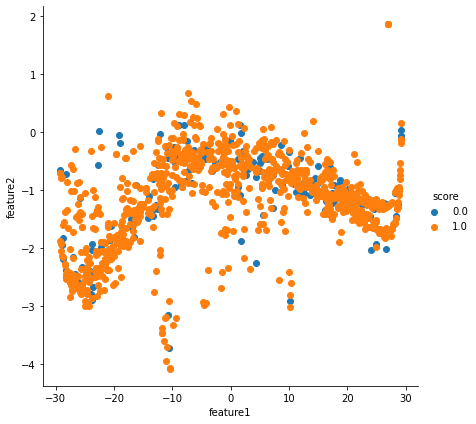

In [140]:
sns.FacetGrid(tfidf_w2v_3d_df , hue = "score" ,height = 6).map(plt.scatter , "feature1" , "feature2").add_legend()
plt.show()